# Librerías

In [1]:
# Tablas
import pandas as pd
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Balanceo
from sklearn.utils import resample

# Preprocesado
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Selección de características
import statsmodels.api as sm
import shap
from sklearn.feature_selection import SelectKBest, f_classif

# Modelado
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

# Evaluación
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics

# Configuración warnings    
import warnings
warnings.filterwarnings('once')

# Lectura y preprocesamiento del dataset 

In [2]:
# LECTURA DEL DATASET
reingresos = pd.read_csv('../HPTU_REINGRESOS_2_30.csv')
reingresos.head(4)

identificador  consecutivo  edad                  descripcion_codigo_4  \
0          17436            1    47  Neumonia bacteriana, no especificada   
1          54447            1    18    Envenenamiento por benzodiazepinas   
2          66277            1    36                       Otras porfirias   
3          70648            1    58     Insuficiencia cardiaca congestiva   

   sum_liq      balances  apache2  glucometria  temp_avg  spo2_avg  ...  \
0  -1995.0  hipovolemico     17.0        133.0     37.08     95.17  ...   
1   -929.0  hipovolemico      9.0         84.0     36.84     93.73  ...   
2  -2130.0  hipovolemico      NaN         84.0     36.74     97.23  ...   
3  -6257.0  hipovolemico      NaN         98.0     36.38     92.20  ...   

   bilirrubina_total  bilirrubina_directa  pcje_basofilos  pcje_bandas  \
0                NaN                  NaN             0.7          NaN   
1                NaN                  NaN             0.2          NaN   
2                NaN                  NaN             0.3          NaN   
3               0.48                 0.48             0.9          NaN   

   anisocitosis  alv_art  acantocitos  dias_estancia  reingreso  \
0           1.0     74.0          0.0            7.8          0   
1           0.0    109.0          0.0            6.2          0   
2           0.0      NaN          0.0            3.0          0   
3           1.0     50.0          0.0            7.9          0   

   dias_reingreso  
0             NaN  
1             NaN  
2             NaN  
3             NaN  

[4 rows x 92 columns]

In [3]:
# LIMPIEZA Y PREPROCESAMIENTO DEL DATASET

# Renombrar la columna del diagnostico prinicipal
reingresos.rename(columns={'descripcion_codigo_4':'diagnostico'}, inplace=True)

# Eliminar filas con valores nulos en las columnas especificadas
reing = reingresos.dropna(subset=['bilirrubina_total', 'apache2', 'temp_avg'], inplace=False).copy()
reing.reset_index(drop=True, inplace=True)

# Eliminar columnas de identificación y columnas con más del 10 % de datos faltantes
reing.drop(columns=['po2_temp', 'ph_temp', 'pco2_temp', 'pcje_mielocitos', 'pcje_metamielocitos', 'cant_magnesio', 
                    'ind_p_f', 'cant_calcio', 'pcje_bandas', 'identificador', 'balances'], inplace=True)

# Eliminar registros con menos de 71 columnas con registros no nulos 
reing.dropna(axis=0, thresh=71, inplace=True)

# Eliminar filas con valores nulos en la columna cant_proteina_c y con valores iguales a 0 en la columna reingreso
reing = reing[reing['cant_proteina_c'].notna() | reing['reingreso'] == 1]

# Categorización de variables numéricas
cambio_4 = ['poiquilocitosis', 'microcitosis', 'macrocitosis', 'hipocromia', 'estomatocitos', 'esquistocitos', 'dianocitos', 
            'crenocitos', 'anisocitosis', 'acantocitos']
reemplazo_cambio_4 = {0:'nulo', 1:'bajo', 2:'moderado', 3:'alto'}
reing[cambio_4] = reing[cambio_4].map(reemplazo_cambio_4.get)
reing['fenomeno_rouleaux'] = reing['fenomeno_rouleaux'].replace({0:'no', 1:'si'}).copy()

# Relleno de valores con diagnóstico desconocido
reing.diagnostico.fillna('Desconocido', inplace=True)

In [4]:
# BALANCEO DE LA CLASE OBJETIVO
df_major = reing[reing.reingreso == 0]
df_minor = reing[reing.reingreso == 1]

# Oversampling para clase minoritaria
df_minor_sample = resample(df_minor,
                           replace=True,
                           n_samples=int(reing.reingreso.value_counts()[0] * 0.2),  # Número de muestras de la clase minoritaria
                           random_state=0)

# Concatenación de clase mayoritaria y nuevo muestreo de clase minoritaria
reing_balanc = pd.concat([df_major, df_minor_sample])

# Undersampling para clase mayoritaria
df_major_sample = resample(reing_balanc[reing_balanc.reingreso == 0],
                           replace=False,
                           n_samples=reing_balanc.reingreso.value_counts()[1],  # Número de muestras de la clase minoritaria
                           random_state=0)

# Concatenación de clase minoritaria y nuevo muestreo de clase mayoritaria
reing_balanc = pd.concat([df_major_sample, reing_balanc[reing_balanc.reingreso == 1]])

# Conteo de valores para cada clase
print(reing_balanc.reingreso.value_counts())

reingreso
0    305
1    305
Name: count, dtype: int64


In [5]:
# ELIMINACIÓN DE COLUMNAS CON UN ÚNICO VALOR (IGUAL A NULO)
reing_balanc.drop(columns='howell_jolly', inplace=True)

# Análisis Exploratorio de los Datos (EDA)

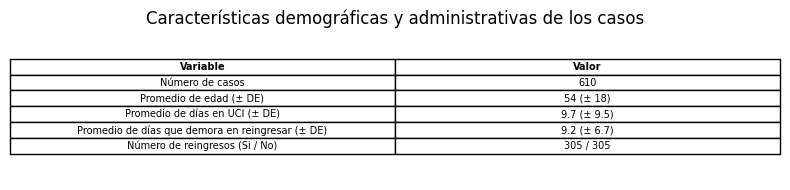

In [6]:
# Cálculo de características
num_casos = reing_balanc.consecutivo.count()
edad_avg = reing_balanc.edad.mean()
edad_std = reing_balanc.edad.std()
dias_avg = reing_balanc.dias_estancia.mean()
dias_std = reing_balanc.dias_estancia.std()
reing_avg = reing_balanc.dias_reingreso.mean()
reing_std = reing_balanc.dias_reingreso.std()

# Crear el DataFrame con las características
grap_data = {
    'Variable': [
                 'Número de casos',
                 'Promedio de edad (± DE)',
                 'Promedio de días en UCI (± DE)',
                 'Promedio de días que demora en reingresar (± DE)',
                 'Número de reingresos (Si / No)'
                 ],
    'Valor': [
        f'{num_casos}',
        f'{edad_avg:.0f} (± {edad_std:.0f})',
        f'{dias_avg:.1f} (± {dias_std:.1f})',
        f'{reing_avg:.1f} (± {reing_std:.1f})',
        f'{reing_balanc.reingreso.value_counts()[1]} / {reing_balanc.reingreso.value_counts()[0]}',
              ]
}
df_data = pd.DataFrame(grap_data)

# Gráfico de la tabla
fig, ax = plt.subplots(figsize=(8, 2))
tb = plt.table(cellText=df_data.values, colLabels=df_data.columns, cellLoc='center', loc='center')

# Ocultar el eje
plt.axis('Off')

# Hacer la primera fila más grande y en negrita
for key, cell in tb.get_celld().items():
    if key[0] == 0:
        cell.set_fontsize(16)
        cell.set_text_props(weight='bold')

plt.title('Características demográficas y administrativas de los casos')

plt.tight_layout();

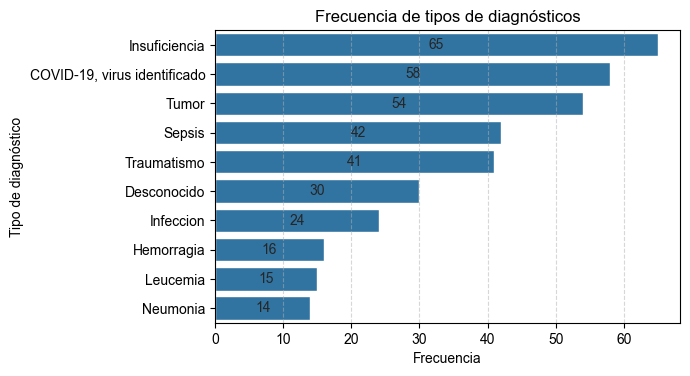

In [7]:
# Creación de dataframe
df_diagn = pd.DataFrame(reing_balanc.diagnostico.value_counts()).reset_index()
df_diagn.columns = ['diagnostico', 'conteo']
df_diagn['tipo'] = ''

# Grupo de enfermedades para agrupar los diagnosticos
enfermedades = ['sepsis', 'tumor', 'traumatismo', 'linfoma', 'neumonia', 'leucemia', 'diabetes',
                'hemorragia', 'fistula', 'cirrosis', 'fractura', 'infarto',
                'hipotension', 'rechazo de', 'peritonitis', 'edema', 'hemotorax', 'polimiositis',
                'quiste', 'tuberculosis', 'insuficiencia', 'embolia', 'varice', 'dermatomiositis',
                'absceso', 'colangitis', 'bloqueo auriculoventricular', 'efecto toxico',
                'envenenamiento', 'gangrena', 'ulcera', 'amputacion', 'infeccion', 'encefalitis', 
                'enfermedades especificadas', 'enfermedad cardiorrenal', 'VIH']

# Creamos la columna del tipo de diagnostico y eliminamos la de diagnostico
for idx, row in df_diagn.iterrows():
    for i in enfermedades:
        if i.lower() in row['diagnostico'].lower():
            df_diagn.loc[idx, 'tipo'] = i.capitalize()
df_diagn['tipo'].where(df_diagn['tipo'] != '', df_diagn['diagnostico'], inplace=True)
df_diagn.tipo.replace({'Efecto toxico': 'Envenenamiento',
                      'Rechazo de': 'Rechazo de trasplante',
                      'Dermatomiositis': 'Polimiositis',
                      'Otras epilepsias': 'Epilepsias',
                      'Epilepsia y sindromes epilepticos idiopaticos generalizados': 'Epilepsia',
                      'Vih': 'VIH', 'Otros estados epilepticos': 'Epilepsia'}, inplace=True)

# Sumamos los conteos de igual tipo
tb = df_diagn.groupby('tipo').sum('conteo').sort_values('conteo', ascending=False)

# Gráfico de conteo de tipo diagnóstico
plt.subplots(figsize=(6, 3.8))
sns.set_style('whitegrid')
ax = sns.barplot(data=tb.head(10), y='tipo', x='conteo')

# Añadir los valores a los gráficos
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Nombre de los ejes
ax.set_xlabel('Frecuencia')
ax.set_ylabel('Tipo de diagnóstico')

# Ajuste del grid
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Añadir título de gráfico
ax.set_title('Frecuencia de tipos de diagnósticos');

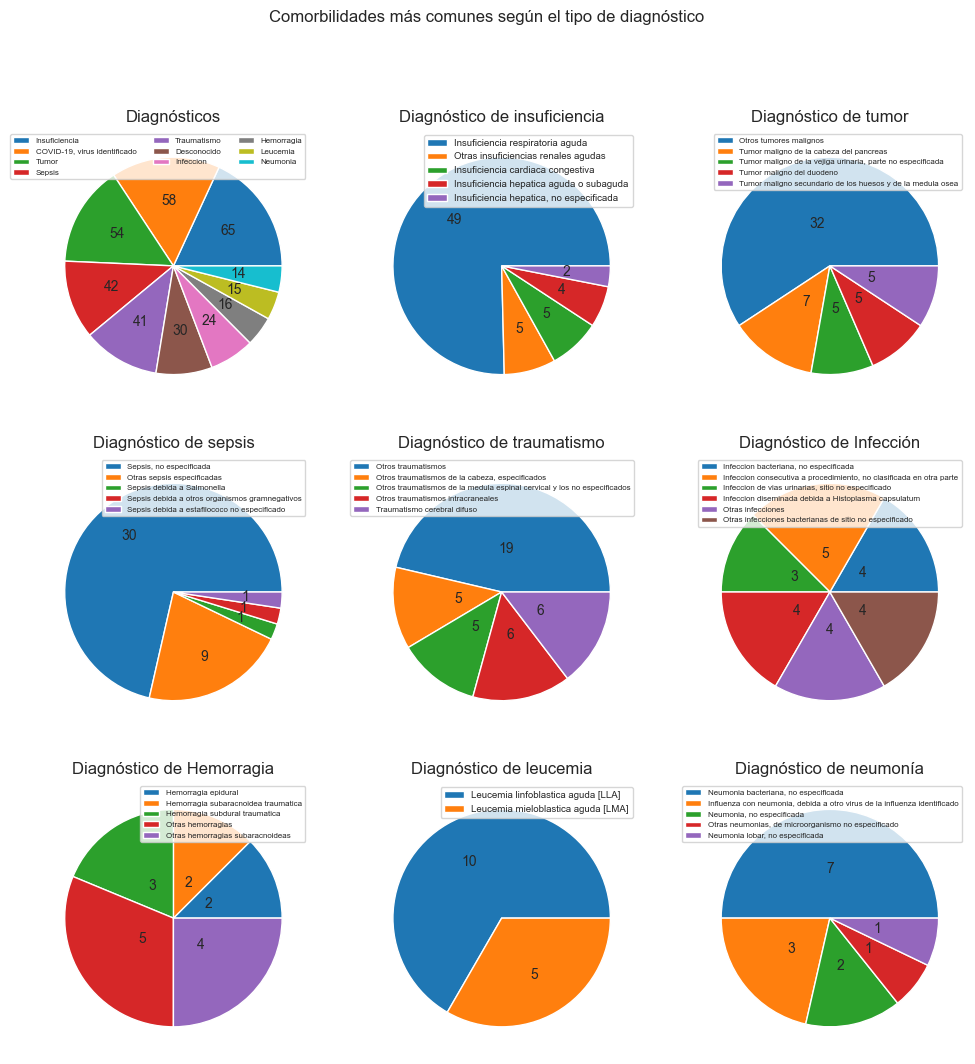

In [8]:
# Cálculo de comorbilidades
insuficiencia = df_diagn[df_diagn['tipo'] == 'Insuficiencia']

df_tumor = df_diagn.copy()
df_tumor['diagnostico'].where(df_tumor['conteo'] > 4 , 'Otros tumores malignos', inplace=True)
tumor = df_tumor[df_tumor['tipo'] == 'Tumor'].groupby('diagnostico').sum('conteo')

sepsis = df_diagn[df_diagn['tipo'] == 'Sepsis']

df_trauma = df_diagn.copy()
df_trauma['diagnostico'].where(df_trauma['conteo'] > 4 , 'Otros traumatismos', inplace=True)
trauma = df_trauma[df_trauma['tipo'] == 'Traumatismo'].groupby('diagnostico').sum('conteo')

df_infe = df_diagn.copy()
df_infe['diagnostico'].where(df_infe['conteo'] > 2 , 'Otras infecciones', inplace=True)
infe = df_infe[df_infe['tipo'] == 'Infeccion'].groupby('diagnostico').sum('conteo')

df_hemo = df_diagn.copy()
df_hemo['diagnostico'].where(df_hemo['conteo'] > 1 , 'Otras hemorragias', inplace=True)
hemo = df_hemo[df_hemo['tipo'] == 'Hemorragia'].groupby('diagnostico').sum('conteo')

leucemia = df_diagn[df_diagn['tipo'] == 'Leucemia']

neumonia = df_diagn[df_diagn['tipo'] == 'Neumonia']

# Gráfico de comorbilidades según el tipo de diagnóstico
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

# Función para mostrar los valores numéricos y no porcentuales
def func(pcje, allvalues):
    absolute = float(pcje/100*sum(allvalues))
    return "{:.0f}".format(absolute)

# Gráfico 1
ax[0,0].pie(x='conteo', labels=tb.head(10).index, data=tb.head(10),
            autopct=lambda pct: func(pct, tb.head(10)['conteo']), labeldistance=None)
ax[0,0].legend(loc='upper right', fontsize='xx-small', ncols=3)
ax[0,0].set_title('Diagnósticos')
#sns.barplot(data=neumonia, x='conteo', y='diagnostico', ax=ax[0, 0])

# Gráfico 2
ax[0,1].pie(x='conteo', labels='diagnostico', data=insuficiencia,
            autopct=lambda pct: func(pct, insuficiencia['conteo']), labeldistance=None)
ax[0,1].legend(loc='upper right', fontsize='x-small')
ax[0,1].set_title('Diagnóstico de insuficiencia')
#sns.barplot(data=insuficiencia, x='conteo', y='diagnostico', ax=ax[0, 1])

# Gráfico 3
ax[0,2].pie(x='conteo', labels=tumor.index, data=tumor,
            autopct=lambda pct: func(pct, tumor['conteo']), labeldistance=None, pctdistance=0.4)
ax[0,2].legend(loc='upper right', fontsize='xx-small')
ax[0,2].set_title('Diagnóstico de tumor')
#sns.barplot(data=tumor, x='conteo', y='diagnostico', ax=ax[0, 2])

# Gráfico 4
ax[1,0].pie(x='conteo', labels='diagnostico', data=sepsis, pctdistance=0.66,
            autopct=lambda pct: func(pct, sepsis['conteo']), labeldistance=None)
ax[1,0].legend(loc='upper right', fontsize='xx-small')
ax[1,0].set_title('Diagnóstico de sepsis')
#sns.barplot(data=sepsis, x='conteo', y='diagnostico', ax=ax[1, 0])

# Gráfico 5
ax[1,1].pie(x='conteo', labels=trauma.index, data=trauma, pctdistance=0.4,
            autopct=lambda pct: func(pct, trauma['conteo']), labeldistance=None)
ax[1,1].legend(loc='upper right', fontsize='xx-small')
ax[1,1].set_title('Diagnóstico de traumatismo')
#sns.barplot(data=traumatismo, x='conteo', y='diagnostico', ax=ax[1, 1])

# Gráfico 6
ax[1,2].pie(x='conteo', labels=infe.index, data=infe, pctdistance=0.35,
            autopct=lambda pct: func(pct, infe['conteo']), labeldistance=None)
ax[1,2].legend(loc='upper right', fontsize='xx-small')
ax[1,2].set_title('Diagnóstico de Infección')
#sns.barplot(data=infe, x='conteo', y='diagnostico', ax=ax[1, 2])

# Gráfico 7
ax[2,0].pie(x='conteo', labels=hemo.index, data=hemo, pctdistance=0.35,
            autopct=lambda pct: func(pct, hemo['conteo']), labeldistance=None)
ax[2,0].legend(loc='upper right', fontsize='xx-small')
ax[2,0].set_title('Diagnóstico de Hemorragia')
#sns.barplot(data=hemo, x='conteo', y='diagnostico', ax=ax[2, 0])

# Gráfico 8
ax[2,1].pie(x='conteo', labels='diagnostico', data=leucemia,
            autopct=lambda pct: func(pct, leucemia['conteo']), labeldistance=None)
ax[2,1].legend(loc='upper right', fontsize='x-small')
ax[2,1].set_title('Diagnóstico de leucemia')
#sns.barplot(data=leucemia, x='conteo', y='diagnostico', ax=ax[2, 1])

# Gráfico 9
ax[2,2].pie(x='conteo', labels='diagnostico', data=neumonia, pctdistance=0.45,
            autopct=lambda pct: func(pct, neumonia['conteo']), labeldistance=None)
ax[2,2].legend(loc='upper right', fontsize='xx-small')
ax[2,2].set_title('Diagnóstico de neumonía')
#sns.barplot(data=neumonia, x='conteo', y='diagnostico', ax=ax[2, 2])

# Título del gráfico
plt.suptitle('Comorbilidades más comunes según el tipo de diagnóstico');

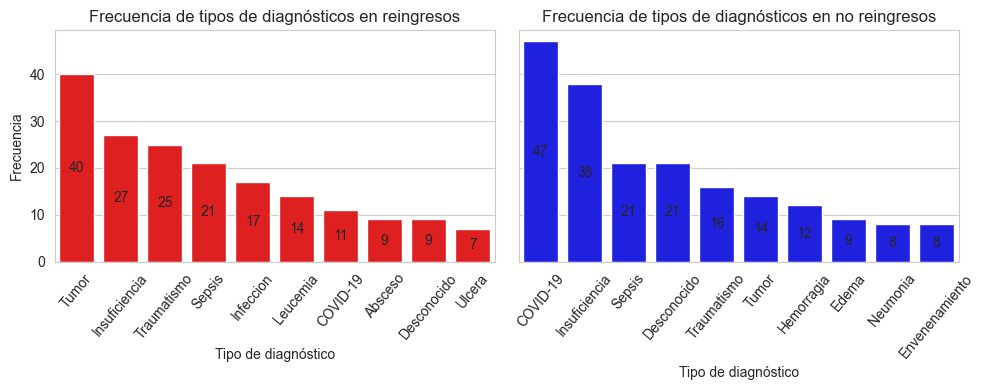

In [9]:
# Creación de Dataframe
df_diagn_reing = pd.DataFrame(reing_balanc[reing_balanc['reingreso'] == 1].diagnostico.value_counts()).reset_index()
df_diagn_reing.columns = ['diagnostico', 'conteo']
df_diagn_reing['tipo'] = ''

df_diagn_no_reing = pd.DataFrame(reing_balanc[reing_balanc['reingreso'] == 0].diagnostico.value_counts()).reset_index()
df_diagn_no_reing.columns = ['diagnostico', 'conteo']
df_diagn_no_reing['tipo'] = ''

#df_diagn_no_reing = 

# Grupo de enfermedades para agrupar los diagnosticos
enfermedades = ['sepsis', 'tumor', 'traumatismo', 'linfoma', 'neumonia', 'leucemia', 'diabetes',
                'hemorragia', 'fistula', 'cirrosis', 'fractura', 'infarto',
                'hipotension', 'rechazo de', 'peritonitis', 'edema', 'hemotorax', 'polimiositis',
                'quiste', 'tuberculosis', 'insuficiencia', 'embolia', 'varice', 'dermatomiositis',
                'absceso', 'colangitis', 'bloqueo auriculoventricular', 'efecto toxico',
                'envenenamiento', 'gangrena', 'ulcera', 'amputacion', 'infeccion', 'encefalitis', 
                'enfermedades especificadas', 'enfermedad cardiorrenal', 'VIH']

# Creamos la columna del tipo de diagnostico y eliminamos la de diagnostico
for df in [df_diagn_reing, df_diagn_no_reing]:
    for idx, row in df.iterrows():
        for i in enfermedades:
            if i.lower() in row['diagnostico'].lower():
                df.loc[idx, 'tipo'] = i.capitalize()
    df['tipo'].where(df['tipo'] != '', df['diagnostico'], inplace=True)
    df.tipo.replace({'Efecto toxico': 'Envenenamiento',
                     'Rechazo de': 'Rechazo de trasplante',
                     'Dermatomiositis': 'Polimiositis',
                     'Otras epilepsias': 'Epilepsias',
                     'Epilepsia y sindromes epilepticos idiopaticos generalizados': 'Epilepsia',
                     'Vih': 'VIH', 'Otros estados epilepticos': 'Epilepsia',
                     'COVID-19, virus identificado': 'COVID-19'}, inplace=True)

# Sumamos los conteos de igual tipo
tb_reing = df_diagn_reing.groupby('tipo').sum('conteo').sort_values('conteo', ascending=False)
tb_no_reing = df_diagn_no_reing.groupby('tipo').sum('conteo').sort_values('conteo', ascending=False)

# Gráfico de conteo de tipo diagnóstico
sns.set_style('whitegrid')
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
sns.barplot(data=tb_reing.head(10), x='tipo', y='conteo', color='r', ax=ax0)
sns.barplot(data=tb_no_reing.head(10), x='tipo', y='conteo', color='b', ax=ax1)

# Añadir los valores a los gráficos
for ax in (ax0, ax1):
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

# Nombrar los ejes
ax0.set_ylabel('Frecuencia')
ax0.set_xlabel('Tipo de diagnóstico')
ax1.set_xlabel('Tipo de diagnóstico')

# Girar nombre de los tipos de diagnóstico
ax0.tick_params(axis='x', rotation=50)
ax1.tick_params(axis='x', rotation=50)

# Añadir títulos a los subgráficos
ax0.set_title('Frecuencia de tipos de diagnósticos en reingresos')
ax1.set_title('Frecuencia de tipos de diagnósticos en no reingresos')

fig.tight_layout();

Text(0.5, 1.0, 'Cantidad de reingresos y de no reingresos')

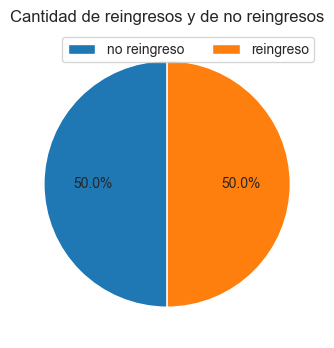

In [10]:
# Gráfico de comorbilidades según el tipo de diagnóstico
fig, ax = plt.subplots(figsize=(4, 4))

# Gráfico
ax.pie(x=reing_balanc.reingreso.value_counts(), labels=['no reingreso', 'reingreso'], 
       autopct='%1.1f%%', labeldistance=None, startangle=90)
ax.legend(loc='upper right', ncols=2)
ax.set_title('Cantidad de reingresos y de no reingresos')

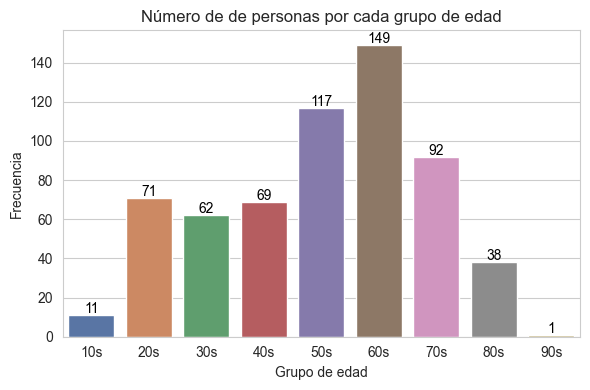

In [11]:
# Copia del dataset para no modificar el original
df_edad = reing_balanc.copy()

# Creamos los grupos de edades
_bins = np.arange(10, 101, 10)
_labels = [f'{i}s' for i in range(10, 100, 10)]

# Creamos una columna que nombra la decada según la edad
df_edad['GRUPOEDAD'] = pd.cut(df_edad['edad'], bins=_bins, labels=_labels, right=False)
conteo_grupo_edad = df_edad.GRUPOEDAD.value_counts().sort_index().reset_index()
conteo_grupo_edad.columns = ['GRUPOEDAD', 'CONTEO']

# Histrograma de edades 
plt.figure(figsize=(6,4))
sns.set_style('whitegrid')
sns.barplot(data=conteo_grupo_edad, x='GRUPOEDAD', y='CONTEO', hue='GRUPOEDAD', palette='deep')

# Título del gráfico
plt.title('Número de de personas por cada grupo de edad')

# Valor de la frecuencia de cada grupo de edad
for _index, _row in conteo_grupo_edad.iterrows():
    plt.text(_index, _row['CONTEO'] + 1, _row['CONTEO'], color='black', ha='center')

# Nombres de los ejes
plt.xlabel('Grupo de edad')
plt.ylabel('Frecuencia')
plt.tight_layout();

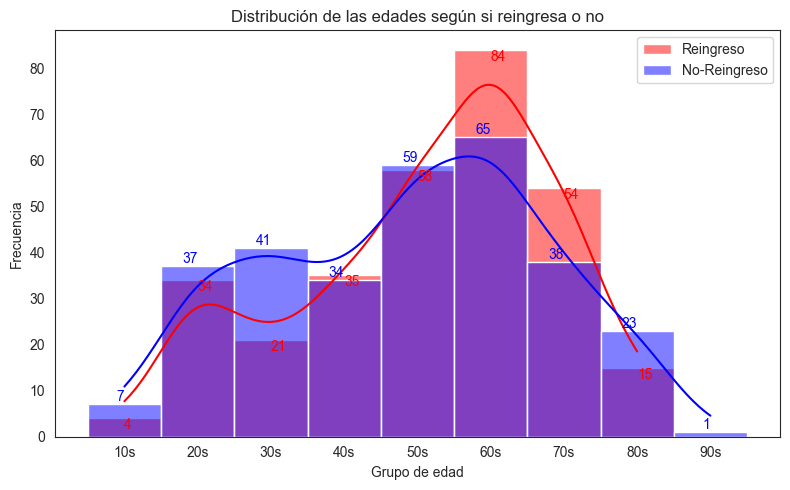

In [12]:
# Crear el gráfico
plt.figure(figsize=(8, 5))

# Crear la distribución de cada grupo de edad para cada clase de reingreso
sns.set_style('white')
h1 = sns.histplot(df_edad[df_edad['reingreso'] == 1]['GRUPOEDAD'], kde=True, binwidth=10, color='red', label='Reingreso')
h0 = sns.histplot(df_edad[df_edad['reingreso'] == 0]['GRUPOEDAD'], kde=True, binwidth=10, color='blue', label='No-Reingreso')

# Frecuencia de cada grupo de edad por cada clase de reingreso
conteo_grupo_edad_r1 = df_edad[df_edad['reingreso'] == 1].GRUPOEDAD.value_counts().sort_index().reset_index()
conteo_grupo_edad_r1.columns = ['GRUPOEDAD', 'CONTEO']
conteo_grupo_edad_r0 = df_edad[df_edad['reingreso'] == 0].GRUPOEDAD.value_counts().sort_index().reset_index()
conteo_grupo_edad_r0.columns = ['GRUPOEDAD', 'CONTEO']

# Valor de la frecuencia de cada grupo de edad para cada clase de reingreso
for _index, _row in conteo_grupo_edad_r1.iterrows():
    if _row['CONTEO'] > 0:
        plt.text(_index, _row['CONTEO'], _row['CONTEO'], color='red', ha='left', va='top')
for _index, _row in conteo_grupo_edad_r0.iterrows():
    if _row['CONTEO'] > 0:
        plt.text(_index, _row['CONTEO'], _row['CONTEO'], color='blue', ha='right', va='bottom')

# Crear la leyenda
plt.legend(loc='best')

# Nombres de los ejes
plt.xlabel('Grupo de edad')
plt.ylabel('Frecuencia')

# Título del gráfico
plt.title('Distribución de las edades según si reingresa o no')

plt.tight_layout();

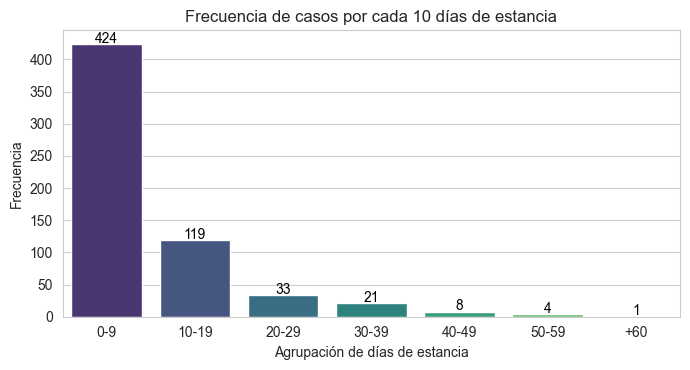

In [13]:
# Gráfico días de estancia 
df_dias_est = reing_balanc.copy()

# Cálculo de días de estancia agrupado por cada diez días
_bins = range(0, 61, 10)
_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59']
df_dias_est['grupo_dias'] = pd.cut(df_dias_est['dias_estancia'], bins=_bins, labels=_labels, right=True)
df_dias_est['grupo_dias'] = np.where(df_dias_est.dias_estancia > 60, "+60", df_dias_est['grupo_dias'])

# Tabla para hacer los gráficos
conteo_grupo_dias = df_dias_est.grupo_dias.value_counts().reset_index()
conteo_grupo_dias.columns = ['grupo_dias', 'conteo']

# Gráfico de barras de los días de estancia
plt.figure(figsize=(7,3.8))
sns.set_style('whitegrid')
sns.barplot(data=conteo_grupo_dias, x='grupo_dias', y='conteo', hue='grupo_dias', palette='viridis')

# Titulo del gráfico
plt.title('Frecuencia de casos por cada 10 días de estancia')

# Valores correspondientes a cada barra
for _index, _row in conteo_grupo_dias.iterrows():
    plt.text(_index, _row['conteo'] + 2, _row['conteo'], color='black', ha='center')

# Nombres de los ejes
plt.xlabel('Agrupación de días de estancia')
plt.ylabel('Frecuencia')

plt.tight_layout();

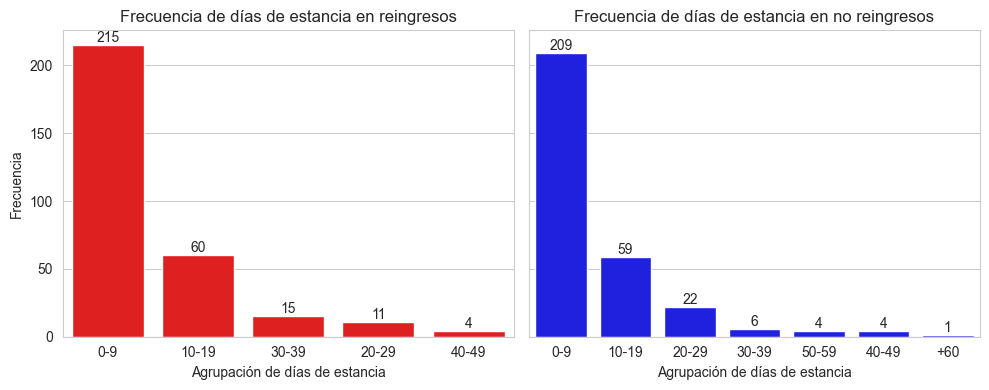

In [14]:
# Gráfico días de estancia según la clase de la variable reingreso

# Tablas para hacer los gráficos
conteo_grupo_dias_reing = df_dias_est[df_dias_est['reingreso'] == 1].grupo_dias.value_counts().reset_index()
conteo_grupo_dias_reing.columns = ['grupo_dias', 'conteo']

conteo_grupo_dias_no_reing = df_dias_est[df_dias_est['reingreso'] == 0].grupo_dias.value_counts().reset_index()
conteo_grupo_dias_no_reing.columns = ['grupo_dias', 'conteo']

# Gráfico de barras de los días de estancia
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharey=True)
sns.set_style('whitegrid')
sns.barplot(data=conteo_grupo_dias_reing, x='grupo_dias', y='conteo', ax=ax0, color='r')
sns.barplot(data=conteo_grupo_dias_no_reing, x='grupo_dias', y='conteo', ax=ax1, color='b')

# Añadir los valores a los gráficos
for ax in (ax0, ax1):
    for container in ax.containers:
        ax.bar_label(container)

# Nombrar los ejes
ax0.set_ylabel('Frecuencia')
ax0.set_xlabel('Agrupación de días de estancia')
ax1.set_xlabel('Agrupación de días de estancia')

# Añadir títulos a los subgráficos
ax0.set_title('Frecuencia de días de estancia en reingresos')
ax1.set_title('Frecuencia de días de estancia en no reingresos')

plt.tight_layout();

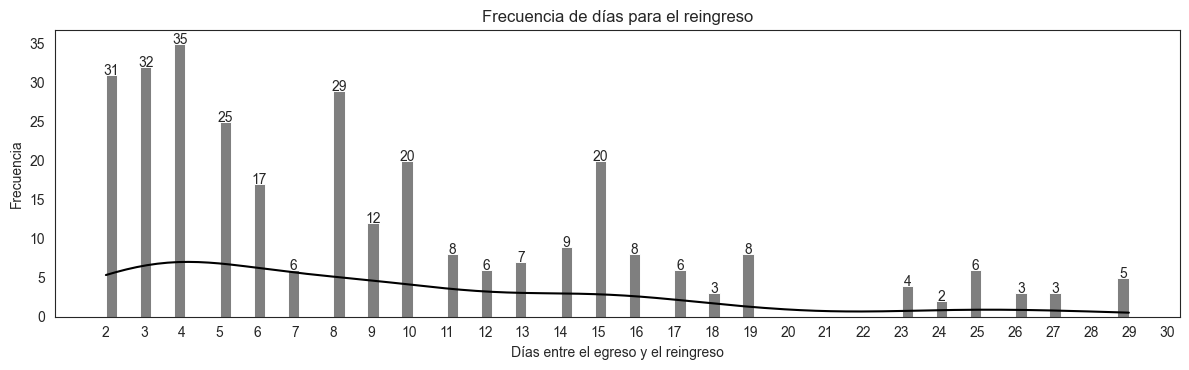

In [15]:
# Gráfico días para el reingreso
df_dias_reing = reing_balanc.copy()

# Gráfico de barras de los días de estancia
plt.figure(figsize=(12, 3.8))
sns.set_style('white')
h = sns.histplot(data=df_dias_reing[df_dias_reing['reingreso'] == 1], x='dias_reingreso',
                 bins=list(range(2, 31, 1)), kde=True, binwidth=0.3, color='k')

# Nombrar ejes
plt.xlabel('Días entre el egreso y el reingreso')
plt.ylabel('Frecuencia')

# Modificar labels del eje x
plt.xticks(ticks=list(range(2, 31, 1)))

# Valor de la frecuencia de cada grupo de edad
for p in h.patches:
    height = p.get_height()
    if height > 0:
        plt.text(p.get_x() + p.get_width() / 2., height,
                 f'{int(height)}', ha='center')

# Titulo del gráfico
plt.title('Frecuencia de días para el reingreso')

plt.tight_layout();

# Columnas usadas

In [7]:
cols_completa = [
            # Variables administrativas
            'consecutivo', 'dias_estancia', 'apache2',
            # Variables sociodemográficas
            'edad',
            # Variables fisiológicas
            'temp_avg', 'spo2_avg', 'pam_avg', 'pa_sistolica_avg', 'pa_diastolica_avg', 'frec_card_avg', 'frec_resp_avg', 'temp_max', 
            'spo2_max', 'pam_max', 'pa_sistolica_max', 'pa_diastolica_max', 'frec_card_max', 'frec_resp_max', 'temp_min', 'spo2_min', 
            'pam_min', 'pa_sistolica_min', 'pa_diastolica_min', 'frec_card_min', 'frec_resp_min', 'temp_std', 'spo2_std', 'pam_std', 
            'pa_sistolica_std', 'pa_diastolica_std', 'frec_card_std', 'frec_resp_std',
            # Variables de laboratorio
            'sum_liq', 'glucometria', 'vpm_fl', 'vcm_fl', 'tco2', 'sodio', 'num_plaquetas', 'num_leucocitos', 'num_eritrocitos', 
            'rdw_pcje', 'cant_proteina_c', 'cant_potasio', 'poiquilocitosis', 'po2', 'ph', 'pco2', 'n_ureico', 'neutrofilos_pcje', 
            'cant_neutrofilos', 'pcje_monocitos', 'microcitosis', 'macrocitosis', 'lactato', 'hipocromia', 'hcm_pg', 'hemoglobina', 
            'pcje_hematocrito', 'pcje_fio2', 'fenomeno_rouleaux', 'estomatocitos', 'esquistocitos', 'pcje_eosinofilos', 'dianocitos',
            'crenocitos','niv_creatinina', 'cant_cloro', 'cc_hcm', 'cant_calcio_ion', 'cant_hco3', 'bilirrubina_total', 
            'bilirrubina_directa', 'pcje_basofilos', 'anisocitosis', 'alv_art', 'acantocitos'
                ]

cols_sin_cat = [
            # Variables administrativas
            'consecutivo', 'dias_estancia', 'apache2',
            # Variables sociodemográficas
            'edad',
            # Variables fisiológicas
            'temp_avg', 'spo2_avg', 'pam_avg', 'pa_sistolica_avg', 'pa_diastolica_avg', 'frec_card_avg', 'frec_resp_avg', 'temp_max', 
            'spo2_max', 'pam_max', 'pa_sistolica_max', 'pa_diastolica_max', 'frec_card_max', 'frec_resp_max', 'temp_min', 'spo2_min', 
            'pam_min', 'pa_sistolica_min', 'pa_diastolica_min', 'frec_card_min', 'frec_resp_min', 'temp_std', 'spo2_std', 'pam_std', 
            'pa_sistolica_std', 'pa_diastolica_std', 'frec_card_std', 'frec_resp_std',
            # Variables de laboratorio
            'sum_liq', 'glucometria', 'vpm_fl', 'vcm_fl', 'tco2', 'sodio', 'num_plaquetas', 'num_leucocitos', 'num_eritrocitos', 
            'rdw_pcje', 'cant_proteina_c', 'cant_potasio', 'po2', 'ph', 'pco2', 'n_ureico', 'neutrofilos_pcje', 'cant_neutrofilos', 
            'pcje_monocitos', 'lactato', 'hcm_pg', 'hemoglobina', 'pcje_hematocrito', 'pcje_fio2', 'pcje_eosinofilos',
            'niv_creatinina', 'cant_cloro', 'cc_hcm', 'cant_calcio_ion', 'cant_hco3', 'bilirrubina_total', 'bilirrubina_directa', 
            'pcje_basofilos', 'alv_art'
               ] 

cols_sin_lab = [
            # Variables administrativas
            'consecutivo', 'dias_estancia', 'apache2',
            # Variables sociodemográficas
            'edad',
            # Variables fisiológicas
            'temp_avg', 'spo2_avg', 'pam_avg', 'pa_sistolica_avg', 'pa_diastolica_avg', 'frec_card_avg', 'frec_resp_avg', 'temp_max', 
            'spo2_max', 'pam_max', 'pa_sistolica_max', 'pa_diastolica_max', 'frec_card_max', 'frec_resp_max', 'temp_min', 'spo2_min', 
            'pam_min', 'pa_sistolica_min', 'pa_diastolica_min', 'frec_card_min', 'frec_resp_min', 'temp_std', 'spo2_std', 'pam_std', 
            'pa_sistolica_std', 'pa_diastolica_std', 'frec_card_std', 'frec_resp_std'
               ]

c_shap_2 = [
            # Variables administrativas
            'consecutivo', 'apache2',
            # Variables fisiológicas
            'temp_avg', 'frec_card_avg', 'pa_diastolica_avg', 'pa_sistolica_avg', 
            # Variables de laboratorio
            'cant_proteina_c', 'lactato', 'po2', 'pcje_monocitos', 'num_eritrocitos', 'niv_creatinina', 'pcje_hematocrito',
            'bilirrubina_total', 'sum_liq',  'rdw_pcje', 'num_plaquetas', 'hemoglobina', 'neutrofilos_pcje'
           ]

# Funciones usadas

In [8]:
# Búsqueda de hiperparámetros con GridSearchCV()
# ==========================================================================================================
def model_gridsearchcv(param_grid, model, cv, x_fit, y_fit):
    """
    Función creada para la implementación del proceso de búsqueda de hiperparámetros óptimos para cada uno
    de los modelos de machine learning que se vayan a crear con la clase GridSearchCV(). La función imprime
    los mejores hiperparámetros encontrados y retorna el modelo entrenado utilizando los mejores 
    hiperparámetros encontrados. En la función se pasan los siguientes parámetros:
        - param_grid: Diccionario de las diferentes combinaciones de hiperparámetros a evaluar.
        - model: Modelo base que se quiere ajustar.
        - cv: Número de particiones para la validación cruzada.
        - x_fit: DataFrame de entrenamiento con características.
        - y_fit: Etiquetas de entrenamiento del modelo.
    """
    # Búsqueda de hiperparámetros
    param_grid = param_grid

    # Objeto GridSearchCV
    logreg_cv = GridSearchCV(estimator=model, 
                             param_grid=param_grid, 
                             cv=cv,
                             refit=True,
                             verbose=1,
                             n_jobs=-1)

    logreg_cv.fit(x_fit, y_fit)

    # Parámetros
    print(f'Parámetros seleccionados: \n {logreg_cv.best_params_}')

    # Modelo generado
    return logreg_cv.best_estimator_

# One-Hot-Encoder y escalado
# ==========================================================================================================
def encoder(x_train, x_test=None):
    """
    Función para preprocesar el conjunto de datos de entrada mediante escalado, aplicado con 
    StandardScaler() a columnas numéricas (media=0, varianza=1); y, proceso de codificación con One-Hot 
    Encoding a las columnas categóricas. La función retorna el DataFrame transformado de entrenamiento si
    sólo se pasa este conjunto de datos; mientras que si se pasa el DataFrame de entrenamiento y el de 
    prueba, la función retorna una tupla con los DataFrames transformados. En la función se pasan los
    siguientes parámetros:
    - x_train: DataFrame de entrenamiento con características.
    - x_test (opcional): DataFrame de prueba con características.
    """
    # Se identifica el nombre de las columnas numéricas y categóricas
    cat_cols = x_train.select_dtypes(include=['object','category']).columns.to_list()
    numeric_cols = x_train.select_dtypes(include=['float64','int64']).columns.to_list()

    # Se aplica one-hot-encoding solo a las columnas categóricas
    preprocessor = ColumnTransformer(
                        [('scale', StandardScaler(), numeric_cols), # media de 0 y varianza de 1
                         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                        remainder='passthrough', 
                        verbose_feature_names_out=False
                        ).set_output(transform='pandas') # Conversión a dataframe

    if x_test is None:
        x_train_prep = preprocessor.fit_transform(x_train)   
        return x_train_prep
    else:
        x_train_prep = preprocessor.fit_transform(x_train)   
        x_test_prep = preprocessor.transform(x_test)

        return x_train_prep, x_test_prep

# DataFrame de comparación de métricas de los modelos creados
# ==========================================================================================================
models = pd.DataFrame(columns=['Dataset', 'Modelo', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC'])
def tabla_modelos(dataset, modelo, accuracy, precision, recall, f1, auc):
    """
    Función para actualizar un DataFrame global con los resultados de todas las métricas de evaluación de
    cada modelo creado. Ordena los resultados en orden descendente por las métricas 'Accuracy' y 'AUC'. 
    Esta tabla permite comparar el desempeño de los diferentes modelos creados. La función retorna un 
    DataFrame ordenado que incluye los resultados actualizados. En la función se pasan los siguientes 
    parámetros:
    - Dataset (str): Nombre del conjunto de datos a utilzar. 
    - Modelo (str): Nombre o identificador del modelo.
    - Accuracy (float): Valor de la métrica Accuracy del modelo.
    - Precision (float): Valor de la métrica Precision del modelo.
    - Recall (float): Valor de la métrica Recall del modelo.
    - F1_score (float): Valor de la métrica F1_score del modelo.
    - AUC (float): Área bajo la curva ROC del modelo.
    """
    global models
    valores = [dataset, modelo, accuracy, precision, recall, f1, auc]
    encontrado = False
    for i in range(len(models)):
        if models.loc[i]['Dataset'] == valores[0] and models.loc[i]['Modelo'] == valores[1]:
            models.loc[i] = valores
            encontrado = True
            break
    if not encontrado:
        models.loc[len(models)] = valores
    return models.sort_values(by=['Accuracy', 'AUC'], ascending=False).reset_index(drop=True)

# Matriz de confusión del modelo
# ==========================================================================================================
def conf_matrix(modelo, x_fit, y_fit, x_test, y_test, ax):
    """
    Esta función entrena un modelo, realiza predicciones y, muestra un informe de clasificación
    y una matriz de confusión en forma de mapa de calor. En la función se pasan los siguientes parámetros:
    - modelo: El modelo de machine learning a entrenar.
    - x_fit: Datos de entrenamiento con características.
    - y_fit: Etiquetas de entrenamiento.
    - x_test: Datos de prueba con características.
    - y_test: Etiquetas de prueba.
    """
    # Entrena el modelo con los datos de entrenamiento
    modelo.fit(x_fit, y_fit)

    # Realiza las predicciones con los datos de prueba
    y_pred = modelo.predict(x_test)

    # Mapa de calor de la matriz de confusión
    ConfMatrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(ConfMatrix, annot=True, cmap='Blues', fmt='d',
                xticklabels=['Non-reingreso', 'reingreso'],
                yticklabels=['Non-reingreso','reingreso'], ax=ax);

# Métricas de evaluación de los modelos
# ==========================================================================================================
def metricas_eval(dataset, n_model, modelo, x_fit, y_fit, x_test, y_test):
    """
    Esta función entrena un modelo, realiza predicciones y calcula métricas de evaluación. La función
    retorna la tabla con los resultados de las métricas de evalución del modelo. En la función se pasan los 
    siguientes parámetros:
    - dataset: Nombre del conjunto de datos a utilizar.
    - n_model: Nombre o identificador del modelo.
    - modelo: El modelo base a entrenar.
    - x_fit: Datos de entrenamiento con características.
    - y_fit: Etiquetas de entrenamiento.
    - x_test: Datos de prueba con características.
    - y_test: Etiquetas de prueba.
    """
    # Entrena el modelo con los datos de entrenamiento
    modelo.fit(x_fit, y_fit)

    #Realiza las predicciones con los datos de prueba
    y_pred = modelo.predict(x_test)

    # Puntuación de la validación cruzada
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    # Guarda los resultados de las métricas en la función que actualiza el DataFrame global
    t = tabla_modelos(dataset, n_model, accuracy, precision, recall, f1, auc)

    grupos = t.groupby('Dataset')

    for categoria, grupo in grupos:
        print(f"\nDataset: {categoria}")
        print(grupo[['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC']])

Muestra de datos para la predicción/validación final de los modelos

In [9]:
reing_balanc.reset_index(drop=True, inplace=True)

In [10]:
## sample devuelve una muestra aleatoria de un eje del objeto.
data = reing_balanc.sample(frac=0.85, random_state=0)

# eliminamos del conjunto de datos original estos datos aleatorios
data_unseen = reing_balanc.drop(data.index)

## restablecemos el índice de ambos conjuntos de datos
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Datos para modelado: ' + str(data.shape))
print('Datos nuevos para predicciones: ' + str(data_unseen.shape))

Datos para modelado: (518, 80)
Datos nuevos para predicciones: (92, 80)


Primera visualización de un análisis de importancia de predictores

<Axes: xlabel='SHAP value (impact on model output)'>

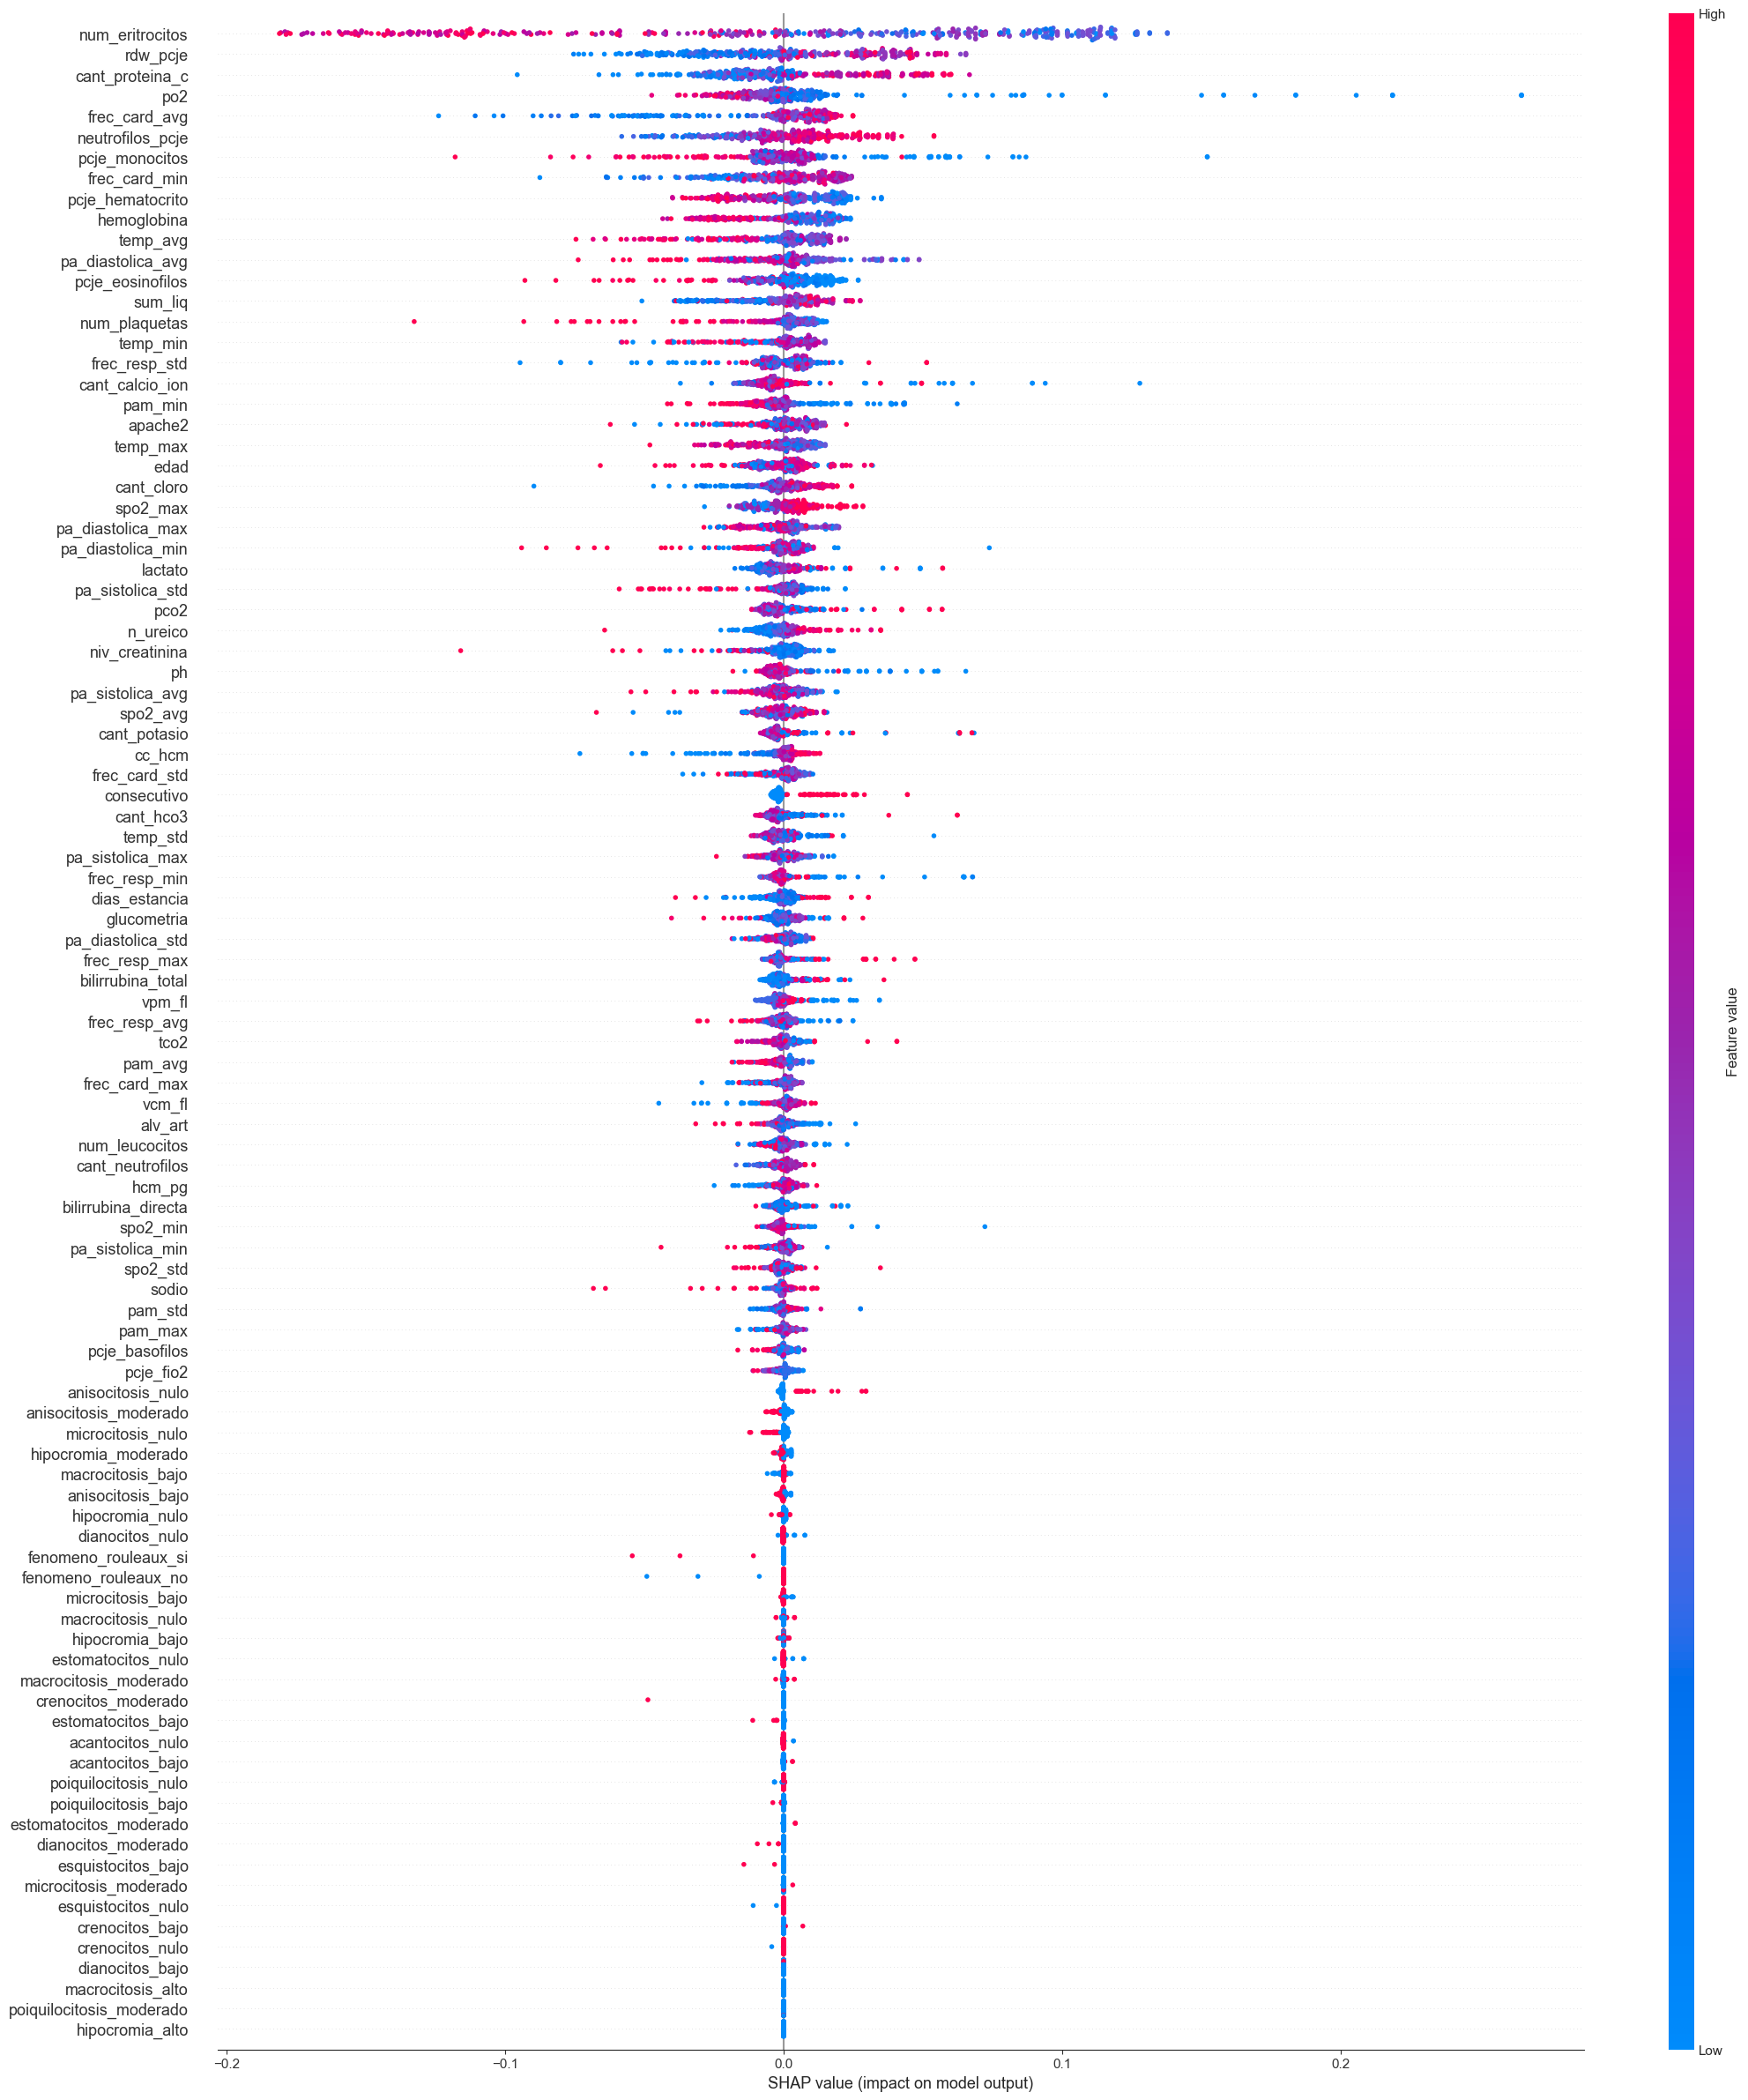

In [21]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(x_train_prep.mean())
x_test_filled = x_test_prep.fillna(x_test_prep.mean())

# Instanciación del modelo
model_shap = RandomForestRegressor()
model_shap.fit(x_train_filled, y_train)

# Crear un objeto explainer de SHAP
explainer = shap.Explainer(model_shap, x_train_filled)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(x_train_filled, check_additivity=False)

# Resumen de la importancia de las características
#shap.summary_plot(shap_values, x_train_filled, feature_names=x_train_filled.columns)
shap.plots.beeswarm(shap_values, max_display=130, plot_size=(25,30), show=False)

# Modelos con el dataset original

In [10]:
cols_completa = [
            # Variables administrativas
            'consecutivo', 'dias_estancia', 'apache2',
            # Variables sociodemográficas
            'edad',
            # Variables fisiológicas
            'temp_avg', 'spo2_avg', 'pam_avg', 'pa_sistolica_avg', 'pa_diastolica_avg', 'frec_card_avg', 'frec_resp_avg', 'temp_max', 
            'spo2_max', 'pam_max', 'pa_sistolica_max', 'pa_diastolica_max', 'frec_card_max', 'frec_resp_max', 'temp_min', 'spo2_min', 
            'pam_min', 'pa_sistolica_min', 'pa_diastolica_min', 'frec_card_min', 'frec_resp_min', 'temp_std', 'spo2_std', 'pam_std', 
            'pa_sistolica_std', 'pa_diastolica_std', 'frec_card_std', 'frec_resp_std',
            # Variables de laboratorio
            'sum_liq', 'glucometria', 'vpm_fl', 'vcm_fl', 'tco2', 'sodio', 'num_plaquetas', 'num_leucocitos', 'num_eritrocitos', 
            'rdw_pcje', 'cant_proteina_c', 'cant_potasio', 'poiquilocitosis', 'po2', 'ph', 'pco2', 'n_ureico', 'neutrofilos_pcje', 
            'cant_neutrofilos', 'pcje_monocitos', 'microcitosis', 'macrocitosis', 'lactato', 'hipocromia', 'hcm_pg', 'hemoglobina', 
            'pcje_hematocrito', 'pcje_fio2', 'fenomeno_rouleaux', 'estomatocitos', 'esquistocitos', 'pcje_eosinofilos', 'dianocitos',
            'crenocitos','niv_creatinina', 'cant_cloro', 'cc_hcm', 'cant_calcio_ion', 'cant_hco3', 'bilirrubina_total', 
            'bilirrubina_directa', 'pcje_basofilos', 'anisocitosis', 'alv_art', 'acantocitos'
                ]

### Regresión logística

In [ ]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(x_train_prep.mean())
x_test_filled = x_test_prep.fillna(x_test_prep.mean())


# Instanciación del modelo
lr_orig = LogisticRegression(solver='lbfgs',
                             C=4.6,
                             max_iter=1000, 
                             random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_completa', 'lr_orig', lr_orig, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
    Modelo  Accuracy  Precision    Recall  F1_score      AUC
0  lr_orig  0.682692   0.666667  0.754717  0.707965  0.68128


### Árbol de decisión

In [ ]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
tree_orig = DecisionTreeClassifier(criterion='gini',
                                   max_depth=9,
                                   max_features='log2',
                                   min_samples_leaf=1,
                                   min_weight_fraction_leaf=0.001,
                                   min_impurity_decrease=0.001,
                                   ccp_alpha=0.00219,
                                   random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_completa', 'tree_orig', tree_orig, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
      Modelo  Accuracy  Precision    Recall  F1_score       AUC
0  tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
1    lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280


### Random Forest

In [ ]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
rf_orig = RandomForestClassifier(criterion='gini',
                                        max_depth=10,
                                        max_features='log2',
                                        n_estimators=50,
                                        random_state=0,
                                        ccp_alpha=0.001)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_completa', 'rf_orig', rf_orig, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
      Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
1  tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
2    lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280


### Gradient Boosting Classifier

In [ ]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
gbc_orig = GradientBoostingClassifier(n_estimators=100,
                                      max_depth=10,
                                      subsample=0.8,
                                      learning_rate=0.01,
                                      min_samples_leaf=1,
                                      random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_completa', 'gbc_orig', gbc_orig, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
      Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
1   gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
2  tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
3    lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280


### XGBoost

In [ ]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Instanciación del modelo
xgb_orig = XGBClassifier(n_estimators=130,
                         max_depth=8,
                         subsample=0.8,
                         learning_rate=0.1,
                         random_state=21)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_completa', 'xgb_orig', xgb_orig, x_train_prep, y_train, x_test_prep, y_test)


Dataset: cols_completa
      Modelo  Accuracy  Precision    Recall  F1_score       AUC
0   xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
1    rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
2   gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
3  tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
4    lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280


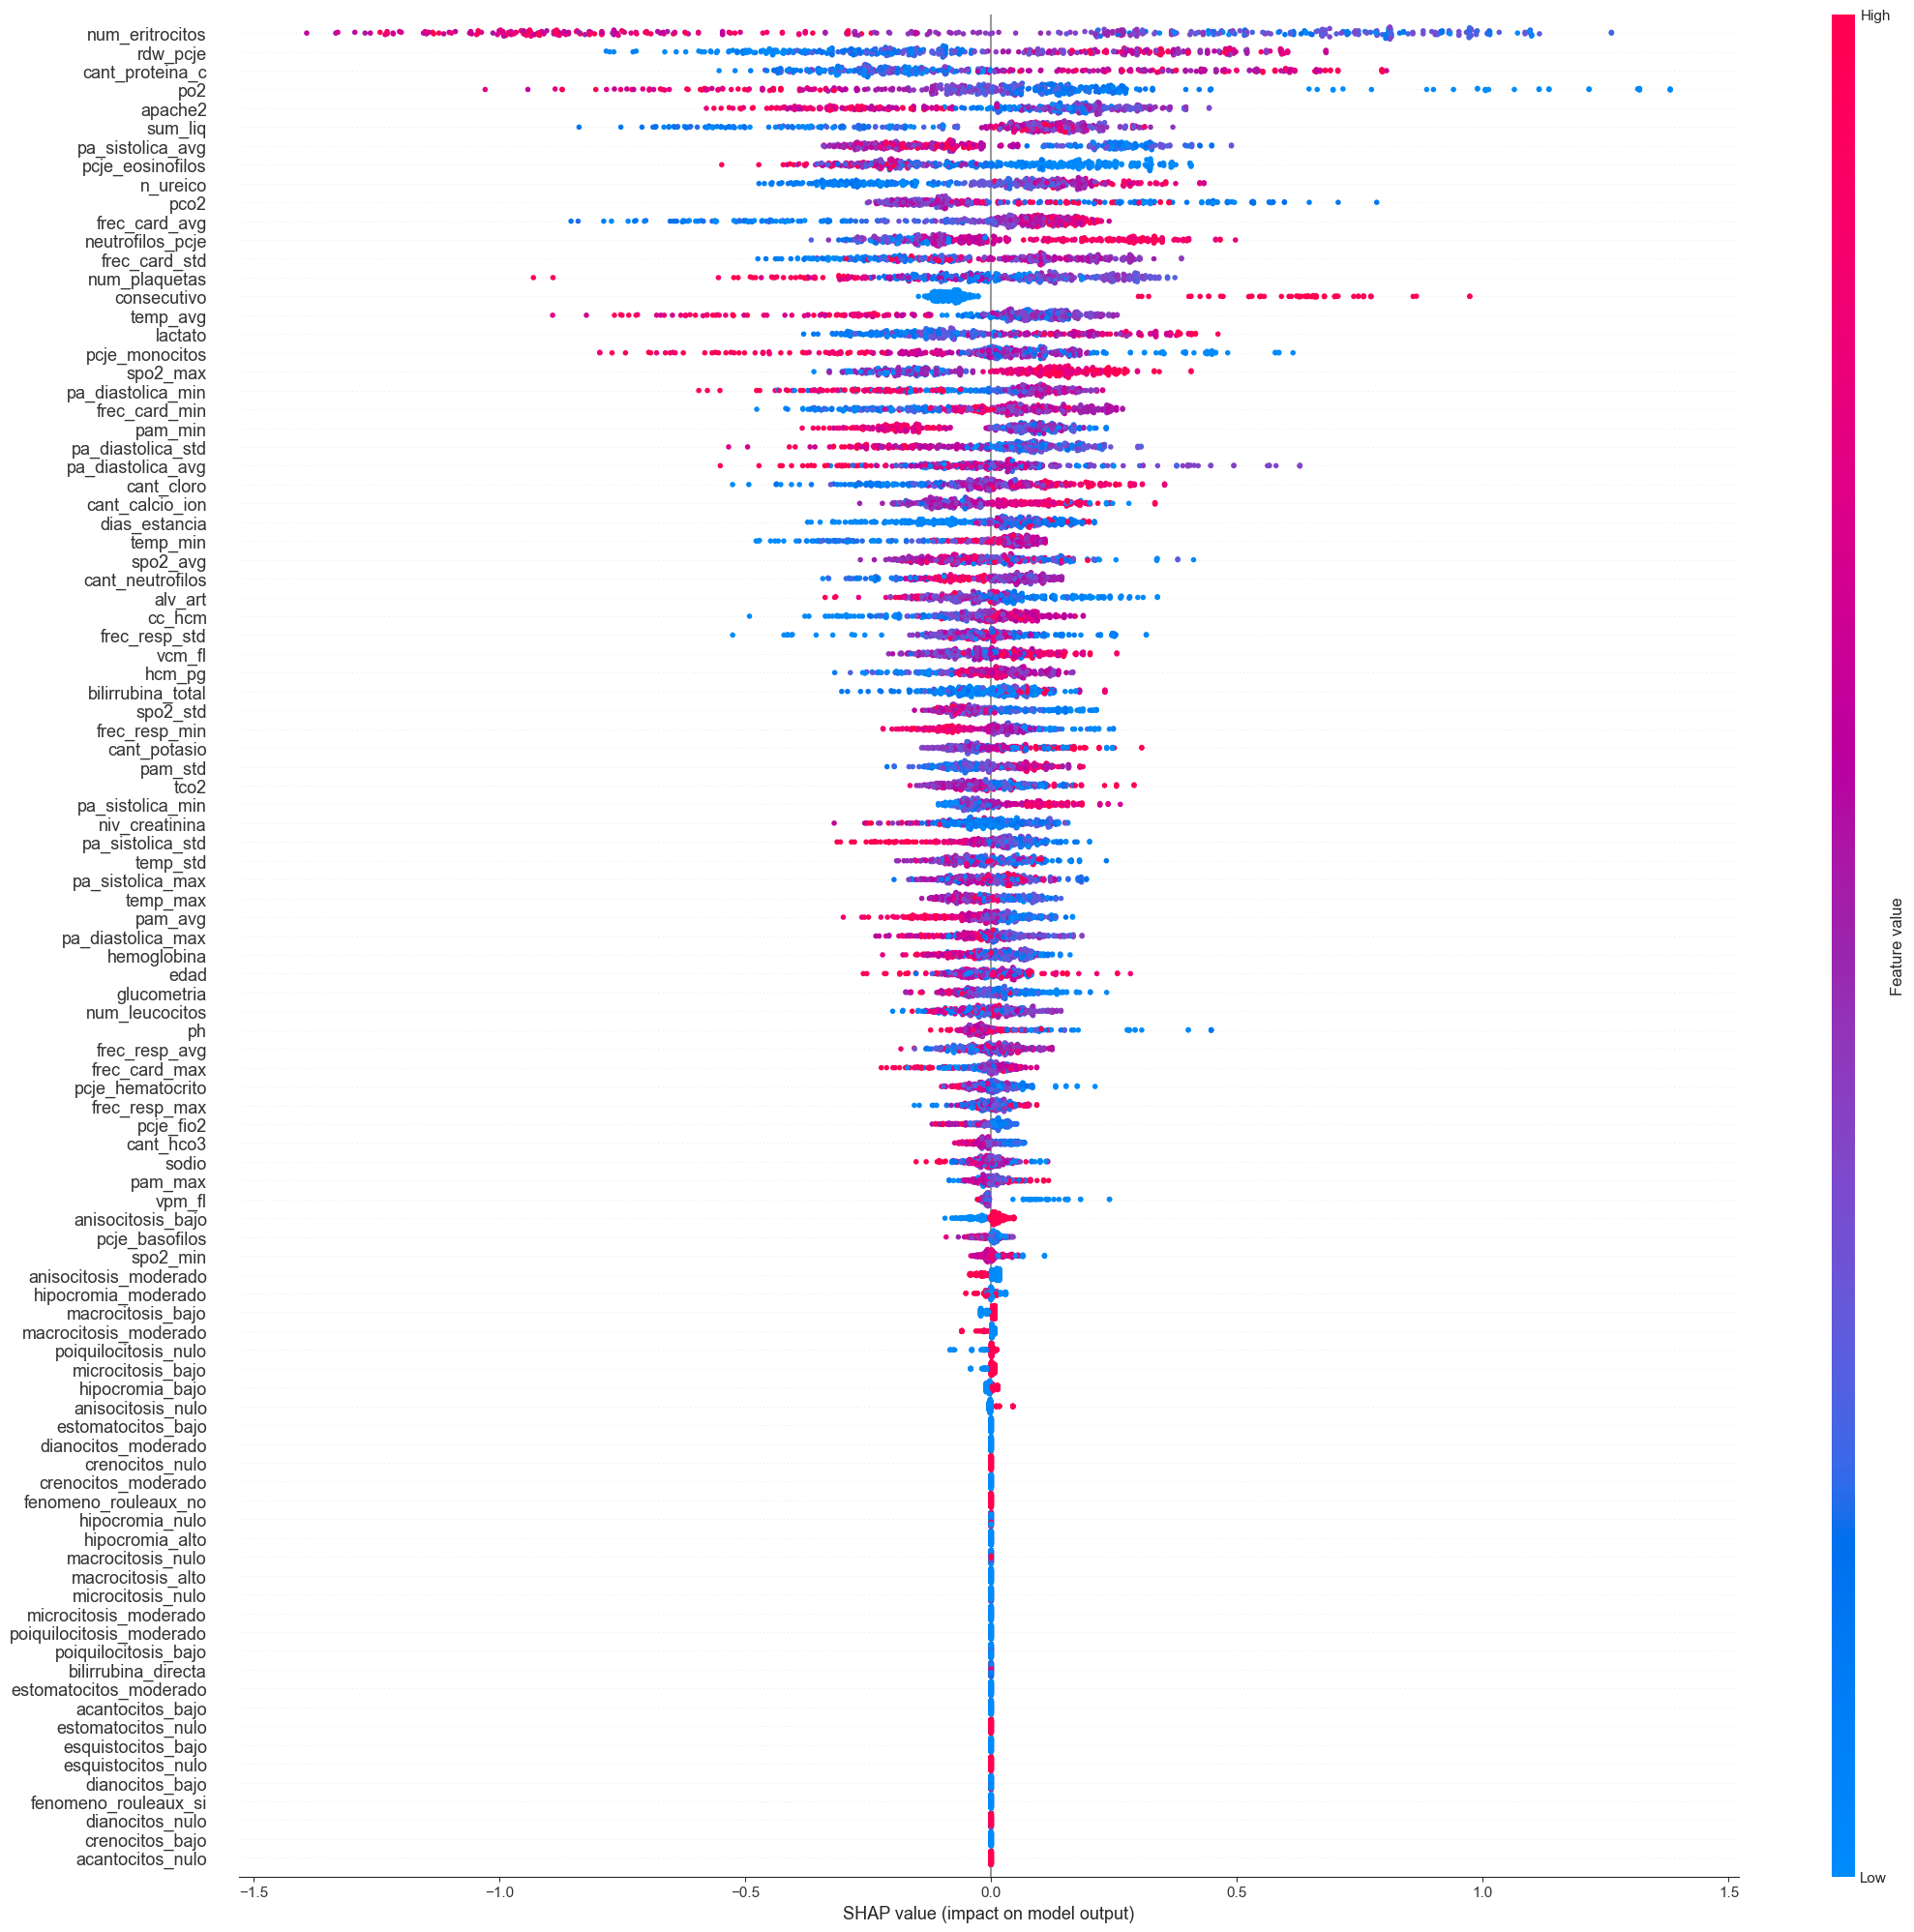

In [29]:
# Crear un objeto explainer de SHAP
explainer = shap.Explainer(xgb_orig, x_train_filled)

# Calcular los valores SHAP para el conjunto de prueba
#shap_values = explainer.shap_values(x_train)
shap_values = explainer(x_train_filled)

# Resumen de la importancia de las características
#shap.summary_plot(shap_values, x_train_filled, feature_names=x_train_filled.columns)
shap.plots.beeswarm(shap_values, max_display=100, plot_size=(25,25))#, show=False)

#plt.savefig('SHAP_XGB_sin_cat.png')

### LightGBM

In [ ]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Búsqueda de hiperparámetros e instanciación del modelo
lgbm_orig = LGBMClassifier(boosting_type='gbdt',
                           n_estimators=300,
                           max_depth=9,
                           subsample=0.8,
                           learning_rate=0.1,
                           subsample_for_bin=200000,
                           random_state=123,
                           verbose=-1)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_completa', 'lgbm_orig', lgbm_orig, x_train_prep, y_train, x_test_prep, y_test)


Dataset: cols_completa
      Modelo  Accuracy  Precision    Recall  F1_score       AUC
0   xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
1  lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
2    rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
3   gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
4  tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
5    lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280


### Adaboosting

In [ ]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Búsqueda de hiperparámetros e instanciación del modelo
ada_orig = AdaBoostClassifier(estimator=rf_orig,
                              n_estimators=50,
                              learning_rate=0.01,
                              algorithm='SAMME',
                              random_state=100)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_completa', 'ada_orig', ada_orig, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
      Modelo  Accuracy  Precision    Recall  F1_score       AUC
0   xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
1  lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
2    rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
3   ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
4   gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
5  tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
6    lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280


### Red neuronal

In [ ]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

red_neuronal = MLPClassifier(hidden_layer_sizes=(35, 35),
                             alpha=0.01,
                             learning_rate_init=0.01,
                             max_iter=1000,
                             solver='adam',
                             activation='tanh',
                             random_state=0,
                             tol=0.00001)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_completa', 'red_neuronal', red_neuronal, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
         Modelo  Accuracy  Precision    Recall  F1_score       AUC
0      xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
1     lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
2       rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
3      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
4  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
5      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
6     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
7       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280


### Stacking model

In [ ]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación de los modelos
estimators = [
              ('xgb', xgb_orig),
              ('dt', tree_orig)
             ]
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(C=1))

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_completa', 'stack_model', stack_model, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
         Modelo  Accuracy  Precision    Recall  F1_score       AUC
0   stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1      xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2     lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3       rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
4      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
5  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
6      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
7     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
8       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280


### Voting

In [ ]:
# Datos para el modelo
x = data[cols_completa]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación de los modelos
# Instanciación de los modelos
estimators = [
              ('xgb', xgb_orig),
              ('gbc', gbc_orig),
             ]
vot = VotingClassifier(estimators=estimators, voting='soft')

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_completa', 'voting', vot, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
         Modelo  Accuracy  Precision    Recall  F1_score       AUC
0   stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1      xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2     lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3       rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
4        voting  0.817308   0.814815  0.830189  0.822430  0.817055
5      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
6  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
7      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
8     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
9       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280


### Matriz de confusión de los primeros tres modelos

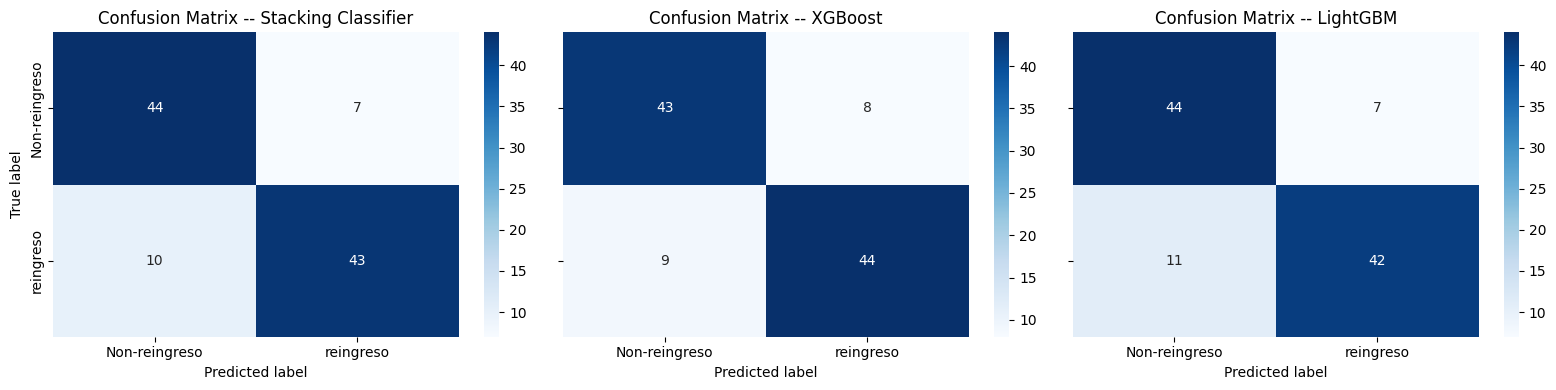

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4), sharey=True)

conf_matrix(stack_model, x_train_filled, y_train, x_test_filled, y_test, ax=ax[0])
ax[0].set_ylabel('True label')
ax[0].set_xlabel('Predicted label')
ax[0].set_title('Confusion Matrix -- Stacking Classifier')
conf_matrix(xgb_orig, x_train_prep, y_train, x_test_prep, y_test, ax=ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_title('Confusion Matrix -- XGBoost')
conf_matrix(lgbm_orig, x_train_prep, y_train, x_test_prep, y_test, ax=ax[2])
ax[2].set_xlabel('Predicted label')
ax[2].set_title('Confusion Matrix -- LightGBM')
plt.tight_layout();

### AUC Models

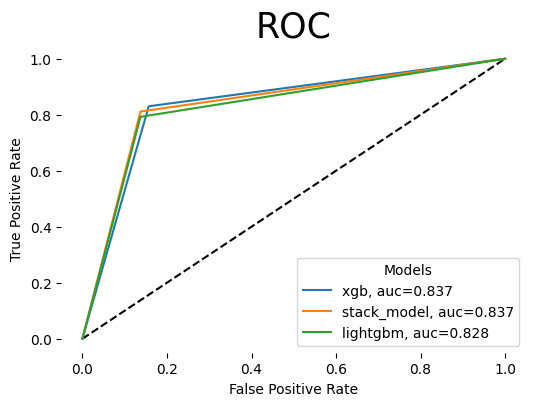

In [24]:
# Para comparar los modelos utilizamos las siguientes métricas: accuracy, precision, recall, f1-score.
# Ahora vamos a usar ROC(Receiver Operating Characteristic) negociación entre sensitivity vs scpecificity
# AUC - área under the curve. Si es grande (cercano a 1) el modelo es bueno distinguiendo entre clases negativas y positivas.
# True positive rate - recall.
# 0.5 indicate that the modelo hasn't power to discreminate between positive and negative classes.

y_pred_proba_xgb = xgb_orig.predict(x_test_prep)
fpr7, tpr7, _ = metrics.roc_curve(y_test, y_pred_proba_xgb)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba_xgb)

y_pred_proba_st = stack_model.predict(x_test_filled)
fpr8, tpr8, _ = metrics.roc_curve(y_test, y_pred_proba_st)
auc8 = metrics.roc_auc_score(y_test, y_pred_proba_st)

y_pred_proba_lgbm = lgbm_orig.predict(x_test_prep)
fpr12, tpr12, _ = metrics.roc_curve(y_test, y_pred_proba_lgbm)
auc12 = metrics.roc_auc_score(y_test, y_pred_proba_lgbm)

plt.figure(figsize=(6, 4))
plt.plot([0,1], [0,1], 'k--')
sns.lineplot(x=fpr7,y=tpr7,label='xgb, auc='+ str(round(auc7,3)))
sns.lineplot(x=fpr8,y=tpr8,label='stack_model, auc='+ str(round(auc8,3)))
sns.lineplot(x=fpr12,y=tpr12,label='lightgbm, auc='+ str(round(auc12,3)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', size=25)
plt.box(False);
#plt.savefig('auc_models1.png', format='png', dpi=300, transparent=True, );

# Modelos sin las variables de laboratorio

In [26]:
cols_sin_lab = [
            # Variables administrativas
            'consecutivo', 'dias_estancia', 'apache2',
            # Variables sociodemográficas
            'edad',
            # Variables fisiológicas
            'temp_avg', 'spo2_avg', 'pam_avg', 'pa_sistolica_avg', 'pa_diastolica_avg', 'frec_card_avg', 'frec_resp_avg', 'temp_max', 
            'spo2_max', 'pam_max', 'pa_sistolica_max', 'pa_diastolica_max', 'frec_card_max', 'frec_resp_max', 'temp_min', 'spo2_min', 
            'pam_min', 'pa_sistolica_min', 'pa_diastolica_min', 'frec_card_min', 'frec_resp_min', 'temp_std', 'spo2_std', 'pam_std', 
            'pa_sistolica_std', 'pa_diastolica_std', 'frec_card_std', 'frec_resp_std'
               ]

### Regresion logística

In [ ]:
# Datos para el modelo
x = data[cols_sin_lab]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(x_train_prep.mean())
x_test_filled = x_test_prep.fillna(x_test_prep.mean())

# Instanciación del modelo
lr_sin_lab = LogisticRegression(solver='lbfgs',
                             C=1,
                             max_iter=1000, 
                             random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_lab', 'lr_sin_lab', lr_sin_lab, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
         Modelo  Accuracy  Precision    Recall  F1_score       AUC
0   stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1      xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2     lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3       rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
4        voting  0.817308   0.814815  0.830189  0.822430  0.817055
5      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
6  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
7      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
8     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
9       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_lab
        Modelo  Accuracy  Precision    Recall  F1_score       AUC
10  lr_sin_lab     0.625      0.625  0.660377  0.642202  0.624306


### Arbol de decision

In [ ]:
# Datos para el modelo
x = data[cols_sin_lab]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
tree_sin_lab = DecisionTreeClassifier(criterion='gini',
                                   max_depth=9,
                                   max_features='log2',
                                   min_samples_leaf=1,
                                   min_weight_fraction_leaf=0.001,
                                   min_impurity_decrease=0.001,
                                   ccp_alpha=0.00219,
                                   random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_lab', 'tree_sin_lab', tree_sin_lab, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
4         voting  0.817308   0.814815  0.830189  0.822430  0.817055
5       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
6   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
7       gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
8      tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
10       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_lab
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
9   tree_sin_lab  0.721154   0.693548  0.811321  0.747826  0.719386
11    lr_sin_lab  0.625000   0.625000  0.660377  0.642202  0.624306


### Random Forest

In [ ]:
# Datos para el modelo
x = data[cols_sin_lab]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
rf_sin_lab = RandomForestClassifier(criterion='gini',
                                        max_depth=10,
                                        max_features='log2',
                                        n_estimators=50,
                                        random_state=0,
                                        ccp_alpha=0.001)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_lab', 'rf_sin_lab', rf_sin_lab, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
4         voting  0.817308   0.814815  0.830189  0.822430  0.817055
5       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
6   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
8       gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
9      tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
11       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_lab
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
7     rf_sin_lab  0.798077   0.820000  0.773585  0.796117  0.798557
10  tree_sin_lab  0.721154   0.693548  0.811321  0.747826  0.719386
1

### Gradient Boosting Classifier

In [ ]:
# Datos para el modelo
x = data[cols_sin_lab]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
gbc_sin_lab = GradientBoostingClassifier(n_estimators=110,
                                      max_depth=13,
                                      subsample=0.8,
                                      learning_rate=0.01,
                                      min_samples_leaf=1,
                                      random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_lab', 'gbc_sin_lab', gbc_sin_lab, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
4         voting  0.817308   0.814815  0.830189  0.822430  0.817055
5       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
6   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
8       gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
9      tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
12       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_lab
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
7     rf_sin_lab  0.798077   0.820000  0.773585  0.796117  0.798557
10   gbc_sin_lab  0.788462   0.792453  0.792453  0.792453  0.788383
1

### XGBoost

In [ ]:
# Datos para el modelo
x = data[cols_sin_lab]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Instanciación del modelo
xgb_sin_lab = XGBClassifier(n_estimators=200,
                         max_depth=12,
                         subsample=0.9,
                         learning_rate=0.1,
                         random_state=21)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_lab', 'xgb_sin_lab', xgb_sin_lab, x_train_prep, y_train, x_test_prep, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
5         voting  0.817308   0.814815  0.830189  0.822430  0.817055
6       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
7   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
9       gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
10     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
13       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_lab
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
4    xgb_sin_lab  0.817308   0.869565  0.754717  0.808081  0.818535
8     rf_sin_lab  0.798077   0.820000  0.773585  0.796117  0.798557
1

### LigthGBM

In [ ]:
# Datos para el modelo
x = data[cols_sin_lab]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Búsqueda de hiperparámetros e instanciación del modelo
lgbm_sin_lab = LGBMClassifier(boosting_type='gbdt',
                           n_estimators=300,
                           max_depth=10,
                           subsample=0.6,
                           learning_rate=0.1,
                           subsample_for_bin=20000,
                           random_state=123,
                           verbose=-1)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_lab', 'lgbm_sin_lab', lgbm_sin_lab, x_train_prep, y_train, x_test_prep, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
6         voting  0.817308   0.814815  0.830189  0.822430  0.817055
7       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
8   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
10      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
11     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
14       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_lab
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
4    xgb_sin_lab  0.817308   0.869565  0.754717  0.808081  0.818535
5   lgbm_sin_lab  0.817308   0.840000  0.792453  0.815534  0.817795
9

### Adaboosting

In [ ]:
# Datos para el modelo
x = data[cols_sin_lab]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Búsqueda de hiperparámetros e instanciación del modelo
ada_sin_lab = AdaBoostClassifier(estimator=rf_sin_lab,
                              n_estimators=50,
                              learning_rate=0.01,
                              algorithm='SAMME',
                              random_state=100)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_lab', 'ada_sin_lab', ada_sin_lab, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
6         voting  0.817308   0.814815  0.830189  0.822430  0.817055
7       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
8   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
10      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
11     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
15       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_lab
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
4    xgb_sin_lab  0.817308   0.869565  0.754717  0.808081  0.818535
5   lgbm_sin_lab  0.817308   0.840000  0.792453  0.815534  0.817795
9

### Red neuronal

In [ ]:
# Datos para el modelo
x = data[cols_sin_lab]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

red_neuronal_sin_lab = MLPClassifier(hidden_layer_sizes=(30, 30),
                             alpha=0.001,
                             learning_rate_init=0.01,
                             max_iter=1000,
                             solver='adam',
                             activation='tanh',
                             random_state=0,
                             tol=0.00001)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_lab', 'red_neuronal_sin_lab', red_neuronal_sin_lab, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
6         voting  0.817308   0.814815  0.830189  0.822430  0.817055
7       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
8   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
10      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
11     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
16       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_lab
                  Modelo  Accuracy  Precision    Recall  F1_score       AUC
4            xgb_sin_lab  0.817308   0.869565  0.754717  0.808081  0.818535
5           lgbm_sin_lab  0.817308   0.840000  0.7924

### Stack model

In [ ]:
# Datos para el modelo
x = data[cols_sin_lab]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación de los modelos
estimators = [
              ('xgb', xgb_sin_lab),
              ('dt', tree_sin_lab)
             ]
stack_model_sin_lab = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(C=1))

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_lab', 'stack_model_sin_lab', stack_model_sin_lab, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
2      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
3        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
6         voting  0.817308   0.814815  0.830189  0.822430  0.817055
7       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
8   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
11      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
12     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
17       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_lab
                  Modelo  Accuracy  Precision    Recall  F1_score       AUC
4            xgb_sin_lab  0.817308   0.869565  0.754717  0.808081  0.818535
5           lgbm_sin_lab  0.817308   0.840000  0.7924

### Voting

In [ ]:
# Datos para el modelo
x = data[cols_sin_lab]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación de los modelos
# Instanciación de los modelos
estimators = [
              ('xgb', xgb_sin_lab),
              ('gbc', gbc_sin_lab),
             ]
vot_sin_lab = VotingClassifier(estimators=estimators, voting='soft')

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_lab', 'vot_sin_lab', vot_sin_lab, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
3      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
4        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
7         voting  0.817308   0.814815  0.830189  0.822430  0.817055
8       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
9   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
12      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
13     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
18       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_lab
                  Modelo  Accuracy  Precision    Recall  F1_score       AUC
2            vot_sin_lab  0.826923   0.872340  0.773585  0.820000  0.827969
5            xgb_sin_lab  0.817308   0.869565  0.7547

### Matriz de confusión de los primeros tres modelos

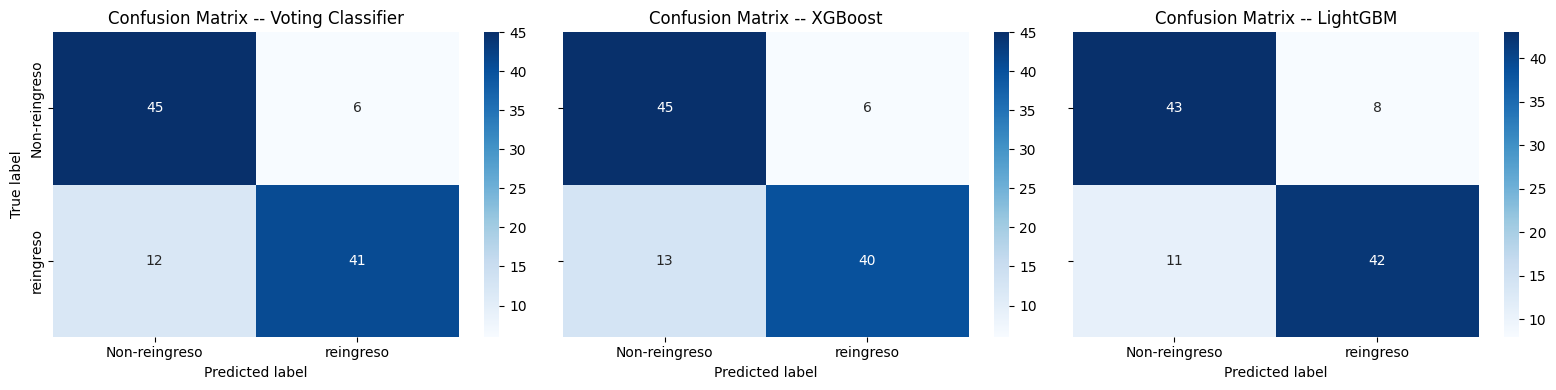

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4), sharey=True)

conf_matrix(vot_sin_lab, x_train_filled, y_train, x_test_filled, y_test, ax=ax[0])
ax[0].set_ylabel('True label')
ax[0].set_xlabel('Predicted label')
ax[0].set_title('Confusion Matrix -- Voting Classifier')
conf_matrix(xgb_sin_lab, x_train_prep, y_train, x_test_prep, y_test, ax=ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_title('Confusion Matrix -- XGBoost')
conf_matrix(lgbm_sin_lab, x_train_prep, y_train, x_test_prep, y_test, ax=ax[2])
ax[2].set_xlabel('Predicted label')
ax[2].set_title('Confusion Matrix -- LightGBM')
plt.tight_layout();

### AUC Models

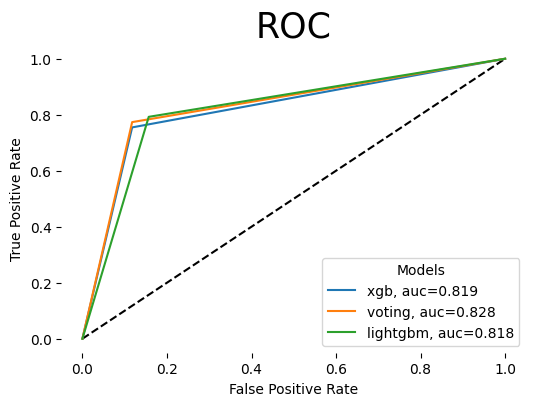

In [38]:
# Para comparar los modelos utilizamos las siguientes métricas: accuracy, precision, recall, f1-score.
# Ahora vamos a usar ROC(Receiver Operating Characteristic) negociación entre sensitivity vs scpecificity
# AUC - área under the curve. Si es grande (cercano a 1) el modelo es bueno distinguiendo entre clases negativas y positivas.
# True positive rate - recall.
# 0.5 indicate that the modelo hasn't power to discreminate between positive and negative classes.
# RF tiene una probabilidad de 77% de distinguir entre default(positivo) y no-default(negativo) clases.
y_pred_proba_xgb = xgb_sin_lab.predict(x_test_prep)
fpr7, tpr7, _ = metrics.roc_curve(y_test, y_pred_proba_xgb)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba_xgb)

y_pred_proba_vt = vot_sin_lab.predict(x_test_filled)
fpr9, tpr9, _ = metrics.roc_curve(y_test, y_pred_proba_vt)
auc9 = metrics.roc_auc_score(y_test, y_pred_proba_vt)

y_pred_proba_lgbm = lgbm_sin_lab.predict(x_test_prep)
fpr12, tpr12, _ = metrics.roc_curve(y_test, y_pred_proba_lgbm)
auc12 = metrics.roc_auc_score(y_test, y_pred_proba_lgbm)

plt.figure(figsize=(6, 4))
plt.plot([0,1], [0,1], 'k--')
sns.lineplot(x=fpr7,y=tpr7,label='xgb, auc='+ str(round(auc7,3)))
sns.lineplot(x=fpr9,y=tpr9,label='voting, auc='+ str(round(auc9,3)))
sns.lineplot(x=fpr12,y=tpr12,label='lightgbm, auc='+ str(round(auc12,3)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', size=25)
plt.box(False);
#plt.savefig('auc_models1.png', format='png', dpi=300, transparent=True, );

# Recorte de variables categóricas por baja influencia predictora

In [39]:
cols_sin_cat = [
            # Variables administrativas
            'consecutivo', 'dias_estancia', 'apache2',
            # Variables sociodemográficas
            'edad',
            # Variables fisiológicas
            'temp_avg', 'spo2_avg', 'pam_avg', 'pa_sistolica_avg', 'pa_diastolica_avg', 'frec_card_avg', 'frec_resp_avg', 'temp_max', 
            'spo2_max', 'pam_max', 'pa_sistolica_max', 'pa_diastolica_max', 'frec_card_max', 'frec_resp_max', 'temp_min', 'spo2_min', 
            'pam_min', 'pa_sistolica_min', 'pa_diastolica_min', 'frec_card_min', 'frec_resp_min', 'temp_std', 'spo2_std', 'pam_std', 
            'pa_sistolica_std', 'pa_diastolica_std', 'frec_card_std', 'frec_resp_std',
            # Variables de laboratorio
            'sum_liq', 'glucometria', 'vpm_fl', 'vcm_fl', 'tco2', 'sodio', 'num_plaquetas', 'num_leucocitos', 'num_eritrocitos', 
            'rdw_pcje', 'cant_proteina_c', 'cant_potasio', 'po2', 'ph', 'pco2', 'n_ureico', 'neutrofilos_pcje', 'cant_neutrofilos', 
            'pcje_monocitos', 'lactato', 'hcm_pg', 'hemoglobina', 'pcje_hematocrito', 'pcje_fio2', 'pcje_eosinofilos',
            'niv_creatinina', 'cant_cloro', 'cc_hcm', 'cant_calcio_ion', 'cant_hco3', 'bilirrubina_total', 'bilirrubina_directa', 
            'pcje_basofilos', 'alv_art'
               ] 

### Regresión logística

In [ ]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(x_train_prep.mean())
x_test_filled = x_test_prep.fillna(x_test_prep.mean())

# Instanciación del modelo
lr_sin_cat = LogisticRegression(solver='lbfgs',
                             C=1,
                             max_iter=1000, 
                             random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_cat', 'lr_sin_cat', lr_sin_cat, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
3      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
4        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
7         voting  0.817308   0.814815  0.830189  0.822430  0.817055
8       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
9   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
12      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
13     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
18       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
        Modelo  Accuracy  Precision    Recall  F1_score       AUC
19  lr_sin_cat  0.663462   0.673077  0.660377  0.666667  0.663522

Dataset: cols_sin_lab
                  Modelo  Accuracy  Precision    R

In [41]:
# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(x_train_filled, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.461520
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              reingreso   No. Observations:                  414
Model:                          Logit   Df Residuals:                      348
Method:                           MLE   Df Model:                           65
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                  0.3339
Time:                        12:26:19   Log-Likelihood:                -191.07
converged:                       True   LL-Null:                       -286.84
Covariance Type:            nonrobust   LLR p-value:                 2.088e-14
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0010      0.135     -0.008      0.994      -0.266       0.264
co

### Árbol de decisión

In [ ]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
tree_sin_cat = DecisionTreeClassifier(criterion='gini',
                                   max_depth=11,
                                   max_features='sqrt',
                                   min_samples_leaf=1,
                                   min_weight_fraction_leaf=0.0,
                                   min_impurity_decrease=0.001,
                                   ccp_alpha=0.00219,
                                   random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_cat', 'tree_sin_cat', tree_sin_cat, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
3      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
4        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
7         voting  0.817308   0.814815  0.830189  0.822430  0.817055
8       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
9   red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
13      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
14     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
19       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
11  tree_sin_cat  0.807692   0.761905  0.905660  0.827586  0.805771
20    lr_sin_cat  0.663462   0.673077  0.660377  0.666667  0.663522



In [ ]:
print('Importancia de los predictores en el modelo')
print('-------------------------------------------')
importancia_predictores = pd.DataFrame(
                                {'predictor':x_train_filled.columns.tolist(),
                                 'importancia':tree_sin_cat.feature_importances_})

importancia_predictores[importancia_predictores.importancia != 0].sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
40      num_eritrocitos     0.098414
9         frec_card_avg     0.073760
58           cant_cloro     0.058328
42      cant_proteina_c     0.051694
8     pa_diastolica_avg     0.050709
36                 tco2     0.045814
20              pam_min     0.040639
3                  edad     0.034585
2               apache2     0.031885
50       pcje_monocitos     0.031240
51              lactato     0.031072
21     pa_sistolica_min     0.028245
22    pa_diastolica_min     0.027232
25             temp_std     0.026585
18             temp_min     0.024637
60      cant_calcio_ion     0.023832
6               pam_avg     0.021696
54     pcje_hematocrito     0.020523
37                sodio     0.020007
62    bilirrubina_total     0.019841
46                 pco2     0.019599
47             n_ureico     0.019498
48     neutrofilos_pcje     0.017893
41             rdw_pcje     0.017593
28     pa_sistolica_std     0.015754
65              alv_art     0.014881
7      pa_sistolica_avg     0.014172
52               hcm_pg     0.013875
24        frec_resp_min     0.013598
15    pa_diastolica_max     0.009301
10        frec_resp_avg     0.009220
5              spo2_avg     0.009212
11             temp_max     0.008503
14     pa_sistolica_max     0.008300
12             spo2_max     0.008267
31        frec_resp_std     0.007937
63  bilirrubina_directa     0.006614
1         dias_estancia     0.006614
17        frec_resp_max     0.005905
39       num_leucocitos     0.004960
27              pam_std     0.004842
16        frec_card_max     0.002723

### Random Forest

In [ ]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
rf_sin_cat = RandomForestClassifier(criterion='gini',
                                        max_depth=10,
                                        max_features='log2',
                                        n_estimators=60,
                                        random_state=0,
                                        ccp_alpha=0.00)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_cat', 'rf_sin_cat', rf_sin_cat, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
3      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
4        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
8         voting  0.817308   0.814815  0.830189  0.822430  0.817055
9       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
10  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
14      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
15     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
20       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
5     rf_sin_cat  0.826923   0.818182  0.849057  0.833333  0.826489
12  tree_sin_cat  0.807692   0.761905  0.905660  0.827586  0.805771
2

In [ ]:
print('Importancia de los predictores en el modelo')
print('-------------------------------------------')
importancia_predictores = pd.DataFrame(
                                {'predictor':x_train_filled.columns.tolist(),
                                 'importancia':rf_sin_cat.feature_importances_})

importancia_predictores[importancia_predictores.importancia != 0].sort_values('importancia', ascending=False).head(20)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
54   pcje_hematocrito     0.035929
40    num_eritrocitos     0.035284
32            sum_liq     0.025206
8   pa_diastolica_avg     0.024845
41           rdw_pcje     0.022802
44                po2     0.022361
53        hemoglobina     0.021754
38      num_plaquetas     0.021393
48   neutrofilos_pcje     0.020503
47           n_ureico     0.020184
51            lactato     0.019953
2             apache2     0.018668
9       frec_card_avg     0.017392
6             pam_avg     0.017385
4            temp_avg     0.017351
23      frec_card_min     0.017135
42    cant_proteina_c     0.017039
10      frec_resp_avg     0.017008
62  bilirrubina_total     0.016879
57     niv_creatinina     0.016430

### Gradient Boosting Classifier

In [ ]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
gbc_sin_cat = GradientBoostingClassifier(n_estimators=110,
                                      max_depth=13,
                                      subsample=0.8,
                                      learning_rate=0.01,
                                      min_samples_leaf=1,
                                      random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_cat', 'gbc_sin_cat', gbc_sin_cat, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
1       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
3      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
4        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
8         voting  0.817308   0.814815  0.830189  0.822430  0.817055
9       ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
10  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
15      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
16     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
21       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
5     rf_sin_cat  0.826923   0.818182  0.849057  0.833333  0.826489
12   gbc_sin_cat  0.807692   0.789474  0.849057  0.818182  0.806881
1

### XGBoost

In [ ]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Instanciación del modelo
xgb_sin_cat = XGBClassifier(n_estimators=200,
                         max_depth=12,
                         subsample=0.9,
                         learning_rate=0.1,
                         random_state=21)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_cat', 'xgb_sin_cat', xgb_sin_cat, x_train_prep, y_train, x_test_prep, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
1    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
2       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
4      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
5        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
9         voting  0.817308   0.814815  0.830189  0.822430  0.817055
10      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
11  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
16      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
17     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
22       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    xgb_sin_cat  0.865385   0.830508  0.924528  0.875000  0.864225
6     rf_sin_cat  0.826923   0.818182  0.849057  0.833333  0.826489
1

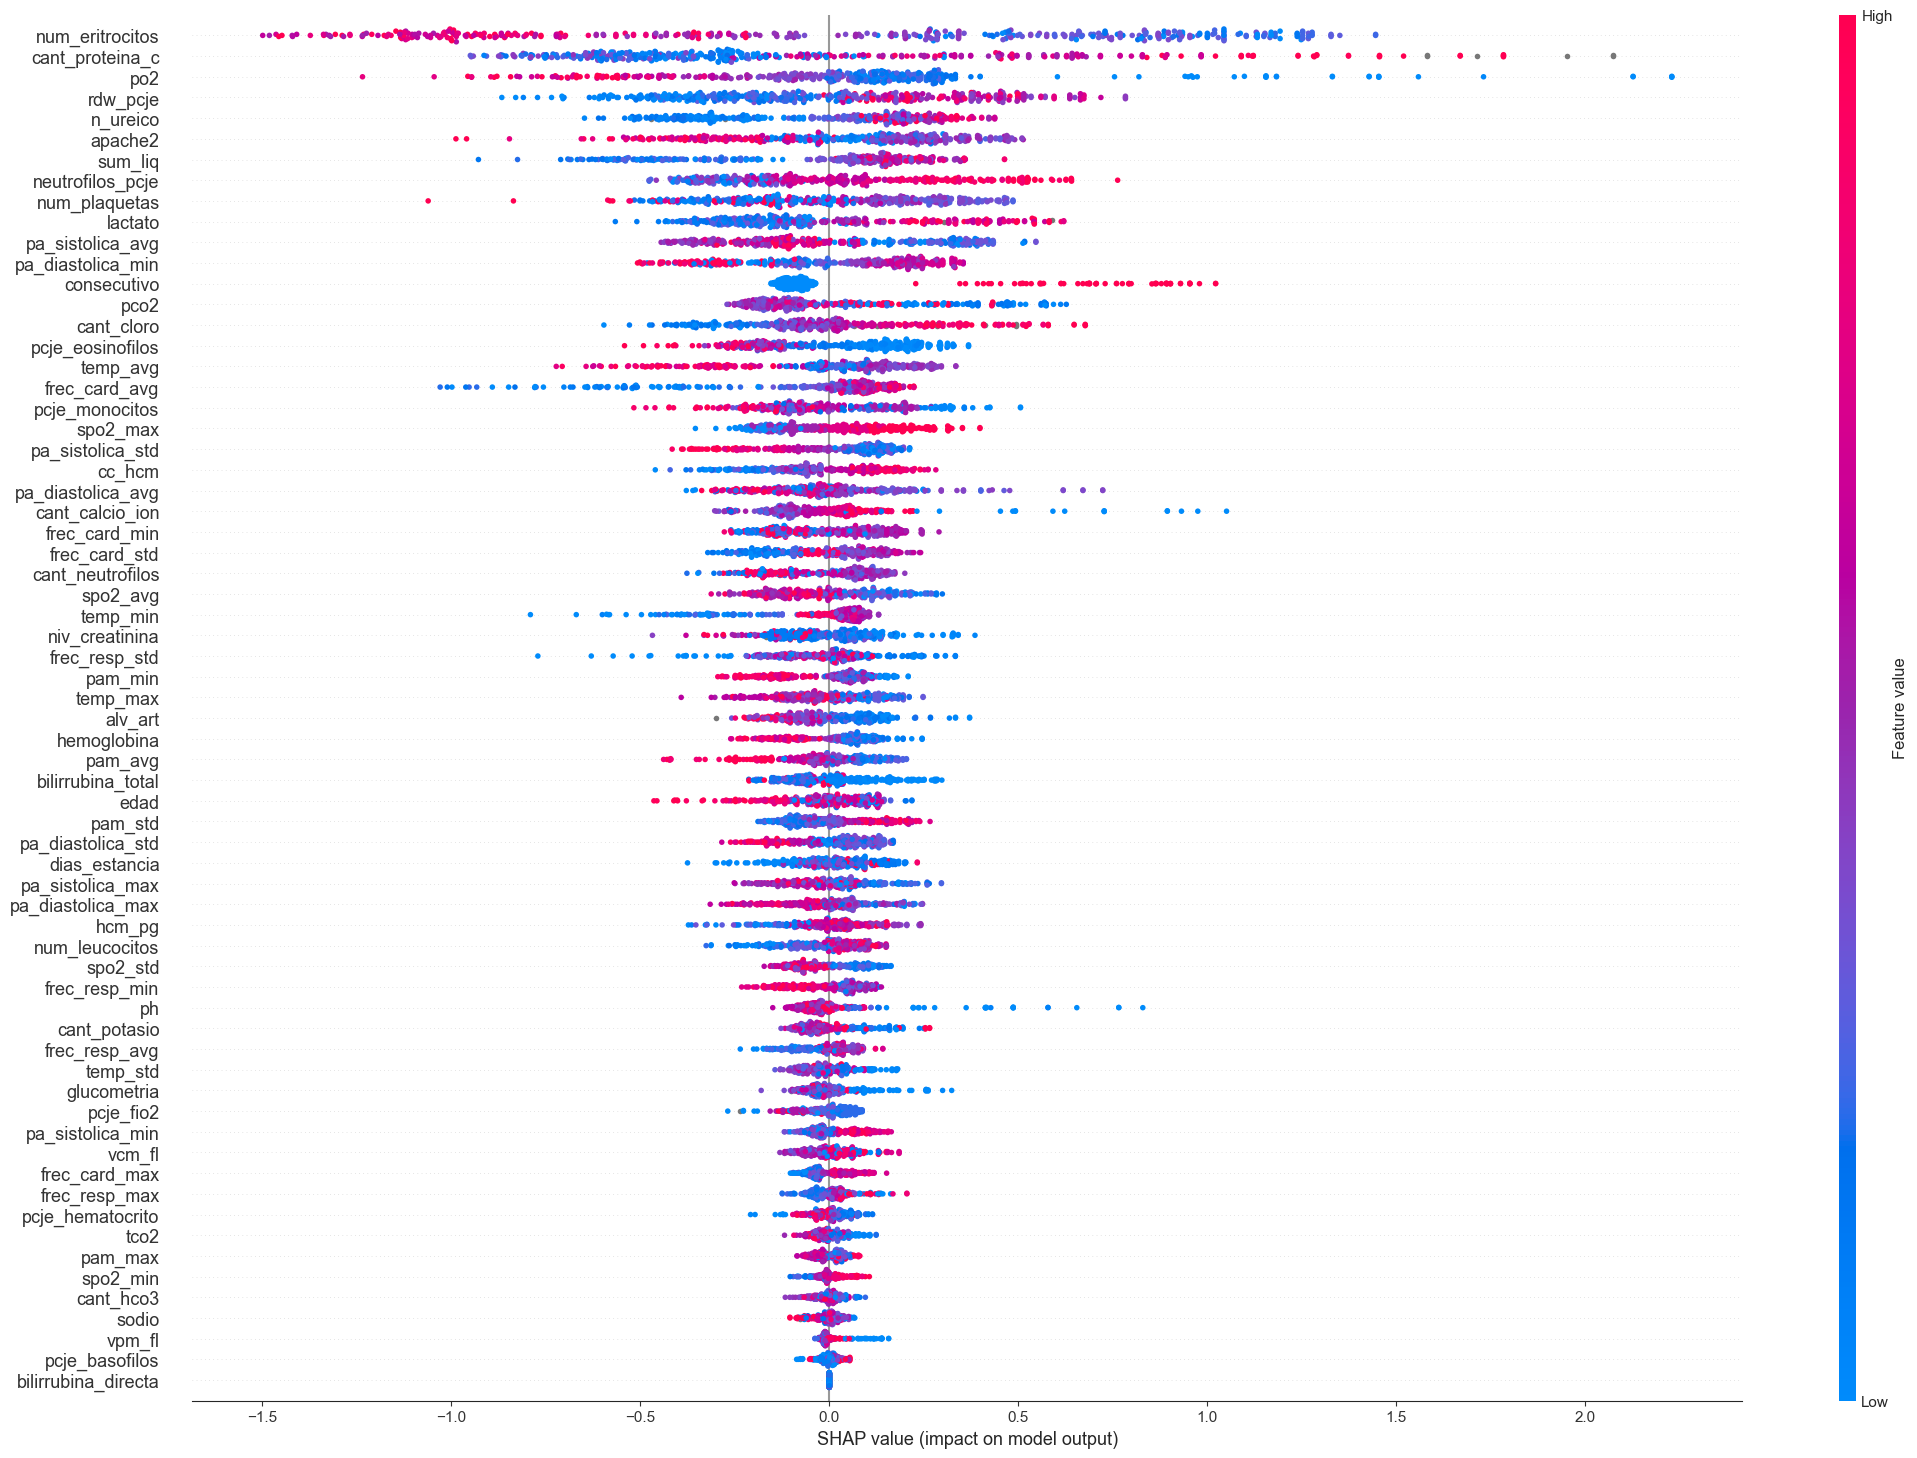

In [63]:
# Crear un objeto explainer de SHAP
explainer = shap.Explainer(xgb_sin_cat, x_train_prep)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(x_train_prep)

# Resumen de la importancia de las características
shap.plots.beeswarm(shap_values, max_display=100, plot_size=(25,18))#, show=False)

#plt.savefig('SHAP_XGB_sin_cat.png')

### LightGBM

In [ ]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Búsqueda de hiperparámetros e instanciación del modelo
lgbm_sin_cat = LGBMClassifier(boosting_type='gbdt',
                           n_estimators=300,
                           max_depth=10,
                           subsample=0.6,
                           learning_rate=0.1,
                           subsample_for_bin=20000,
                           random_state=123,
                           verbose=-1)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_cat', 'lgbm_sin_cat', lgbm_sin_cat, x_train_prep, y_train, x_test_prep, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
1    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
2       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
4      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
5        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
9         voting  0.817308   0.814815  0.830189  0.822430  0.817055
10      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
11  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
16      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
17     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
23       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    xgb_sin_cat  0.865385   0.830508  0.924528  0.875000  0.864225
6     rf_sin_cat  0.826923   0.818182  0.849057  0.833333  0.826489
1

### Adaboosting

In [ ]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Búsqueda de hiperparámetros e instanciación del modelo
ada_sin_cat = AdaBoostClassifier(estimator=rf_sin_cat,
                              n_estimators=50,
                              learning_rate=0.01,
                              algorithm='SAMME',
                              random_state=100)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_cat', 'ada_sin_cat', ada_sin_cat, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
1    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
2       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
4      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
5        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
9         voting  0.817308   0.814815  0.830189  0.822430  0.817055
11      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
12  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
17      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
18     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
24       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    xgb_sin_cat  0.865385   0.830508  0.924528  0.875000  0.864225
6     rf_sin_cat  0.826923   0.818182  0.849057  0.833333  0.826489
1

### Red neuronal

In [ ]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

red_neuronal_sin_cat = MLPClassifier(hidden_layer_sizes=(30, 30),
                             alpha=0.001,
                             learning_rate_init=0.01,
                             max_iter=1000,
                             solver='adam',
                             activation='tanh',
                             random_state=0,
                             tol=0.00001)

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_cat', 'red_neuronal_sin_cat', red_neuronal_sin_cat, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
1    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
2       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
4      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
5        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
9         voting  0.817308   0.814815  0.830189  0.822430  0.817055
11      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
12  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
17      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
18     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
25       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
                  Modelo  Accuracy  Precision    Recall  F1_score       AUC
0            xgb_sin_cat  0.865385   0.830508  0.924528  0.875000  0.864225
6             rf_sin_cat  0.826923   0.818182  0.8490

### Stacking model

In [ ]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación de los modelos
estimators = [
              ('xgb', xgb_sin_cat),
              ('rf', rf_sin_cat)
             ]
stack_model_sin_cat = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(C=1))

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_cat', 'stack_model_sin_cat', stack_model_sin_cat, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
1    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
2       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
5      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
6        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
10        voting  0.817308   0.814815  0.830189  0.822430  0.817055
12      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
13  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
18      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
19     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
26       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
                  Modelo  Accuracy  Precision    Recall  F1_score       AUC
0            xgb_sin_cat  0.865385   0.830508  0.924528  0.875000  0.864225
3    stack_model_sin_cat  0.826923   0.888889  0.7547

### Voting

In [ ]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación de los modelos
# Instanciación de los modelos
estimators = [
              ('xgb', xgb_sin_cat),
              ('rf', rf_sin_cat)
             ]
vot_sin_cat = VotingClassifier(estimators=estimators, voting='soft')

# Métricas de evaluación de la predicción del modelo
metricas_eval('cols_sin_cat', 'vot_sin_cat', vot_sin_cat, x_train_filled, y_train, x_test_filled, y_test)


Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
2    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
3       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
6      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
7        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
11        voting  0.817308   0.814815  0.830189  0.822430  0.817055
13      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
14  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
19      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
20     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
27       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
                  Modelo  Accuracy  Precision    Recall  F1_score       AUC
0            xgb_sin_cat  0.865385   0.830508  0.924528  0.875000  0.864225
1            vot_sin_cat  0.846154   0.862745  0.8301

### Matriz de confusión de los primeros tres modelos

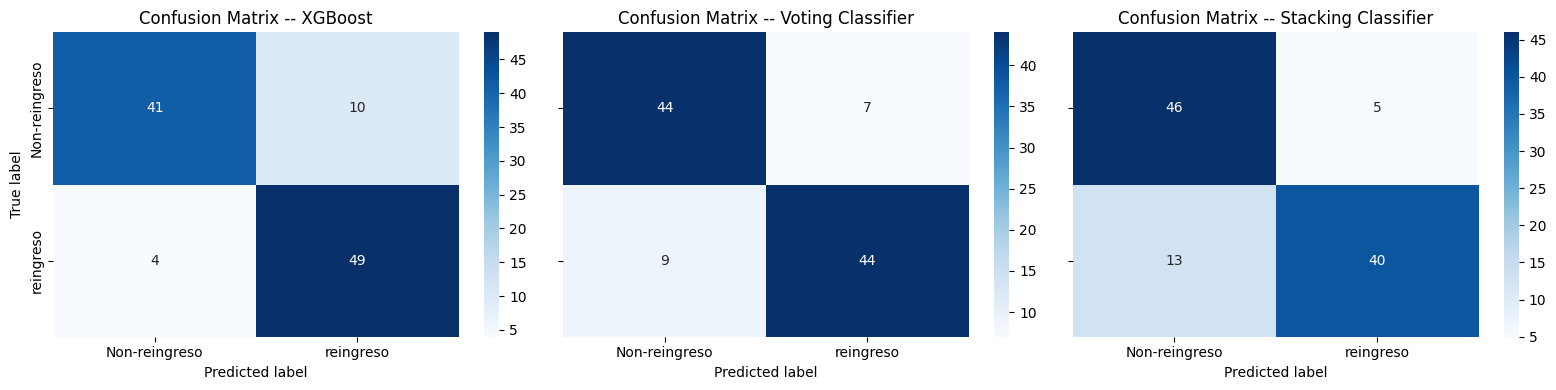

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4), sharey=True)

conf_matrix(xgb_sin_cat, x_train_prep, y_train, x_test_prep, y_test, ax=ax[0])
ax[0].set_ylabel('True label')
ax[0].set_xlabel('Predicted label')
ax[0].set_title('Confusion Matrix -- XGBoost')
conf_matrix(vot_sin_cat, x_train_filled, y_train, x_test_filled, y_test, ax=ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_title('Confusion Matrix -- Voting Classifier')
conf_matrix(stack_model_sin_cat, x_train_filled, y_train, x_test_filled, y_test, ax=ax[2])
ax[2].set_xlabel('Predicted label')
ax[2].set_title('Confusion Matrix -- Stacking Classifier')
plt.tight_layout();

### AUC Models

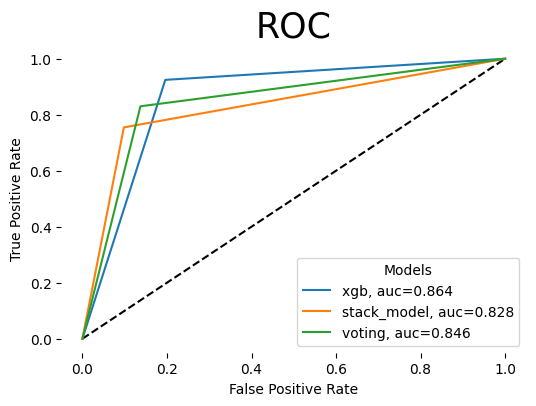

In [54]:
# Para comparar los modelos utilizamos las siguientes métricas: accuracy, precision, recall, f1-score.
# Ahora vamos a usar ROC(Receiver Operating Characteristic) negociación entre sensitivity vs scpecificity
# AUC - área under the curve. Si es grande (cercano a 1) el modelo es bueno distinguiendo entre clases negativas y positivas.
# True positive rate - recall.
# 0.5 indicate that the modelo hasn't power to discreminate between positive and negative classes.
# RF tiene una probabilidad de 77% de distinguir entre default(positivo) y no-default(negativo) clases.
y_pred_proba_xgb = xgb_sin_cat.predict(x_test_prep)
fpr7, tpr7, _ = metrics.roc_curve(y_test, y_pred_proba_xgb)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba_xgb)

y_pred_proba_st = stack_model_sin_cat.predict(x_test_filled)
fpr8, tpr8, _ = metrics.roc_curve(y_test, y_pred_proba_st)
auc8 = metrics.roc_auc_score(y_test, y_pred_proba_st)

y_pred_proba_vt = vot_sin_cat.predict(x_test_filled)
fpr9, tpr9, _ = metrics.roc_curve(y_test, y_pred_proba_vt)
auc9 = metrics.roc_auc_score(y_test, y_pred_proba_vt)

plt.figure(figsize=(6, 4))
plt.plot([0,1], [0,1], 'k--')
sns.lineplot(x=fpr7,y=tpr7,label='xgb, auc='+ str(round(auc7,3)))
sns.lineplot(x=fpr8,y=tpr8,label='stack_model, auc='+ str(round(auc8,3)))
sns.lineplot(x=fpr9,y=tpr9,label='voting, auc='+ str(round(auc9,3)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', size=25)
plt.box(False);
#plt.savefig('auc_models1.png', format='png', dpi=300, transparent=True, );

### Selección de características con SelectKBest()

In [55]:
# Datos para el modelo
x = data[cols_sin_cat]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Seleccionar las mejores características
selector = SelectKBest(score_func=f_classif, k=20)
X_new = selector.fit_transform(x_train_filled, y_train)

# Obtener los nombres de las columnas seleccionadas
#mask = selector.get_support()  # Lista booleana de las características seleccionadas
#selected_features = x_train_filled.columns[mask]
#selected_features

scores = selector.scores_
importances = sorted(zip(scores, range(len(scores))), reverse=True)

# Mostrar las características ordenadas por importancia
for score, index in importances:
    print(f"Característica {x_train_filled.columns[index]} tiene una puntuación de {score}")

Característica num_eritrocitos tiene una puntuación de 32.85214370119581
Característica pcje_hematocrito tiene una puntuación de 31.09227610964989
Característica hemoglobina tiene una puntuación de 29.833634440067012
Característica rdw_pcje tiene una puntuación de 14.18195151809919
Característica consecutivo tiene una puntuación de 13.323539404811909
Característica cant_proteina_c tiene una puntuación de 12.885386124999958
Característica frec_card_avg tiene una puntuación de 9.565413443123479
Característica cant_cloro tiene una puntuación de 9.296862538555613
Característica spo2_max tiene una puntuación de 9.25814091241999
Característica pcje_monocitos tiene una puntuación de 9.13283965452181
Característica num_plaquetas tiene una puntuación de 8.229714056764353
Característica pcje_eosinofilos tiene una puntuación de 8.133831503536738
Característica po2 tiene una puntuación de 7.726308067003137
Característica lactato tiene una puntuación de 7.205625022535869
Característica frec_card_mi

In [56]:
resultados = []

for score, index in importances:
    # Agregar cada característica y su score como tupla a la lista
    resultados.append((x_train_filled.columns[index], score))

# Crear el DataFrame a partir de la lista de tuplas
df_resultados = pd.DataFrame(resultados, columns=['Característica', 'Puntuación'])

# Mostrar el DataFrame
df_resultados.head(20)

Característica  Puntuación
0       num_eritrocitos   32.852144
1      pcje_hematocrito   31.092276
2           hemoglobina   29.833634
3              rdw_pcje   14.181952
4           consecutivo   13.323539
5       cant_proteina_c   12.885386
6         frec_card_avg    9.565413
7            cant_cloro    9.296863
8              spo2_max    9.258141
9        pcje_monocitos    9.132840
10        num_plaquetas    8.229714
11     pcje_eosinofilos    8.133832
12                  po2    7.726308
13              lactato    7.205625
14        frec_card_min    6.831647
15  bilirrubina_directa    6.735967
16    bilirrubina_total    6.735967
17    pa_diastolica_avg    5.306942
18              sum_liq    5.073846
19       pcje_basofilos    4.391165

### Selección de características con Backward y Forward Selection()

In [57]:
# Funciones de seleccion forward y backward para modelos lineales de statsmodels
# ==============================================================================

def forward_selection(
    X: pd.DataFrame,
    y: pd.Series,
    criterio: str='aic',
    add_constant: bool=True,
    verbose: bool=True
)-> list:

    """
    Realiza un procedimiento de selección de variables hacia adelante (forward)
    utilizando como criterio de bondad la métrica especificada. El procedimiento
    se detiene cuando no es posible mejorar más el modelo añadiendo variables.

    Parameters
    ----------
    X: pd.DataFrame
        Matriz de predictores
    y: pd.Series
        Variable respuesta
    metrica: str, default='aic'
        Métrica utilizada para seleccionar las variables. Debe ser una de las
        siguientes opciones: 'aic', 'bic', 'rsquared_adj'.
    add_constant: bool, default=True
        Si `True` añade una columna de 1s a la matriz de predictores con el
        con el nombre de intercept.
    verbose: bool, default=True
        Si `True` muestra por pantalla los resultados de cada iteración.

    Returns
    -------
    seleccion: list
        Lista con las variables seleccionadas.
    """

    if add_constant:
        X = sm.add_constant(X, prepend=True).rename(columns={'const':'intercept'})

    restantes = X.columns.to_list()
    seleccion = []
    if criterio == 'rsquared_adj':
        mejor_metrica = -np.inf
        ultima_metrica = -np.inf
    else:
        mejor_metrica = np.inf
        ultima_metrica = np.inf

    while restantes:
        metricas = []
        for candidata in restantes:
            seleccion_temp = seleccion + [candidata]
            modelo  = sm.OLS(endog=y, exog=X[seleccion_temp])
            modelo_res = modelo.fit()
            metrica = getattr(modelo_res, criterio)
            metricas.append(metrica)
        if criterio == 'rsquared_adj':
            mejor_metrica = max(metricas)
            if mejor_metrica > ultima_metrica:
                mejor_variable = restantes[np.argmax(metricas)]
            else:
                break
        else:
            mejor_metrica = min(metricas)
            if mejor_metrica < ultima_metrica:
                mejor_variable = restantes[np.argmin(metricas)]
            else:
                break

        seleccion.append(mejor_variable)
        restantes.remove(mejor_variable)
        ultima_metrica = mejor_metrica

        if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    return sorted(seleccion)


def backward_selection(
    X: pd.DataFrame,
    y: pd.Series,
    criterio: str='aic',
    add_constant: bool=True,
    verbose: bool=True
)-> list:

    """
    Realiza un procedimiento de selección de variables hacia atrás (backward)
    utilizando como criterio de bondad la métrica especificada. El procedimiento
    se detiene cuando no es posible mejorar más el modelo eliminando variables.

    Parameters
    ----------
    X: pd.DataFrame
        Matriz de predictores
    y: pd.Series
        Variable respuesta
    metrica: str, default='aic'
        Métrica utilizada para seleccionar las variables. Debe ser una de las
        siguientes opciones: 'aic', 'bic', 'rsquared_adj'.
    add_constant: bool, default=True
        Si `True` añade una columna de 1s a la matriz de predictores con el
        con el nombre de intercept.
    verbose: bool, default=True
        Si `True` muestra por pantalla los resultados de cada iteración.

    Returns
    -------
    seleccion: list
        Lista con las variables seleccionadas.
    """

    if add_constant:
        X = sm.add_constant(X, prepend=True).rename(columns={'const':'intercept'})

    # Se inicia con todas las variables como predictores
    seleccion = X.columns.to_list()
    modelo  = sm.OLS(endog=y, exog=X[seleccion])
    modelo_res = modelo.fit()
    ultima_metrica = getattr(modelo_res, criterio)
    mejor_metrica = ultima_metrica
    if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    while seleccion:
        metricas = []
        for candidata in seleccion:
            seleccion_temp = seleccion.copy()
            seleccion_temp.remove(candidata)
            modelo  = sm.OLS(endog=y, exog=X[seleccion_temp])
            modelo_res = modelo.fit()
            metrica = getattr(modelo_res, criterio)
            metricas.append(metrica)
        if criterio == 'rsquared_adj':
            mejor_metrica = max(metricas)
            if mejor_metrica > ultima_metrica:
                peor_variable = seleccion[np.argmax(metricas)]
            else:
                break
        else:
            mejor_metrica = min(metricas)
            if mejor_metrica < ultima_metrica:
                peor_variable = seleccion[np.argmin(metricas)]
            else:
                break

        seleccion.remove(peor_variable)
        ultima_metrica = mejor_metrica

        if verbose:
            print(f'variables: {seleccion} | {criterio}: {mejor_metrica:.3f}')

    return sorted(seleccion)

In [61]:
# Selección de variables hacia forward
# ==============================================================================
predictores_forw = forward_selection(
    X            = x_train_filled,
    y            = y_train,
    criterio     = 'aic',
    add_constant = False, # Ya se le añadió anteriormente
    verbose      = False
)
predictores_forw

['cant_proteina_c',
 'consecutivo',
 'lactato',
 'niv_creatinina',
 'num_eritrocitos',
 'pa_sistolica_min',
 'pam_avg',
 'pcje_monocitos',
 'po2',
 'spo2_max']

In [60]:
predictores_back = backward_selection(
    X            = x_train_filled,
    y            = y_train,
    criterio     = 'aic',
    add_constant = False, # Ya se le añadió anteriormente
    verbose      = False
)
predictores_back

['bilirrubina_directa',
 'bilirrubina_total',
 'cant_proteina_c',
 'consecutivo',
 'frec_card_avg',
 'lactato',
 'niv_creatinina',
 'pa_sistolica_max',
 'pa_sistolica_std',
 'pam_avg',
 'pam_std',
 'pcje_hematocrito',
 'pcje_monocitos',
 'po2']

# Modelos con selección de variables

In [62]:
c_shap_2 = [
            # Variables administrativas
            'consecutivo', 'apache2',
            # Variables fisiológicas
            'temp_avg', 'frec_card_avg', 'pa_diastolica_avg', 'pa_sistolica_avg', 
            # Variables de laboratorio
            'cant_proteina_c', 'lactato', 'po2', 'pcje_monocitos', 'num_eritrocitos', 'niv_creatinina', 'pcje_hematocrito',
            'bilirrubina_total', 'sum_liq',  'rdw_pcje', 'num_plaquetas', 'hemoglobina', 'neutrofilos_pcje'
           ]

### Regresión logística

In [ ]:
# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(x_train_prep.mean())
x_test_filled = x_test_prep.fillna(x_test_prep.mean())

# Instanciación del modelo
lr_shap_2 = LogisticRegression(solver='lbfgs',
                             C=0.01,
                             max_iter=1000, 
                             random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'lr_feat_eng', lr_shap_2, x_train_filled, y_train, x_test_filled, y_test)


Dataset: c_shap_2
         Modelo  Accuracy  Precision    Recall  F1_score       AUC
29  lr_feat_eng  0.653846   0.654545  0.679245  0.666667  0.653348

Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
2    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
3       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
6      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
7        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
11        voting  0.817308   0.814815  0.830189  0.822430  0.817055
13      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
14  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
19      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
20     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
27       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

Dataset: cols_sin_cat
                  Modelo  Accuracy  Precision    Rec

### Árbol de decisión

In [ ]:
# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
tree_shap_2 = DecisionTreeClassifier(criterion='gini',
                                   max_depth=13,
                                   max_features='log2',
                                   min_samples_leaf=1,
                                   min_weight_fraction_leaf=0.0,
                                   min_impurity_decrease=0.001,
                                   ccp_alpha=0.0,
                                   random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'tree_feat_eng', tree_shap_2, x_train_filled, y_train, x_test_filled, y_test)


Dataset: c_shap_2
           Modelo  Accuracy  Precision    Recall  F1_score       AUC
25  tree_feat_eng  0.740385   0.716667  0.811321  0.761062  0.738994
30    lr_feat_eng  0.653846   0.654545  0.679245  0.666667  0.653348

Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
2    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
3       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
6      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
7        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
11        voting  0.817308   0.814815  0.830189  0.822430  0.817055
13      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
14  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
19      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
20     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
28       lr_orig  0.682692   0.666667  0.754717  0.707965  0.681280

D

### Random Forest

In [ ]:
# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
rf_shap_2 = RandomForestClassifier(criterion='gini',
                                        max_depth=7,
                                        max_features='log2',
                                        n_estimators=50,
                                        random_state=0,
                                        ccp_alpha=0.0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'rf_feat_eng', rf_shap_2, x_train_filled, y_train, x_test_filled, y_test)


Dataset: c_shap_2
           Modelo  Accuracy  Precision    Recall  F1_score       AUC
15    rf_feat_eng  0.817308   0.774194  0.905660  0.834783  0.815575
26  tree_feat_eng  0.740385   0.716667  0.811321  0.761062  0.738994
31    lr_feat_eng  0.653846   0.654545  0.679245  0.666667  0.653348

Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
2    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
3       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
6      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
7        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
11        voting  0.817308   0.814815  0.830189  0.822430  0.817055
13      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
14  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
20      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077
21     tree_orig  0.798077   0.758065  0.886792  0.817391  0.796337
2

### Gradient Boosting Classifier

In [ ]:
# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación del modelo
gbc_shap_2 = GradientBoostingClassifier(n_estimators=100,
                                      max_depth=10,
                                      subsample=0.8,
                                      learning_rate=0.01,
                                      min_samples_leaf=1,
                                      random_state=0)

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'gbc_feat_eng', gbc_shap_2, x_train_filled, y_train, x_test_filled, y_test)


Dataset: c_shap_2
           Modelo  Accuracy  Precision    Recall  F1_score       AUC
9    gbc_feat_eng  0.826923   0.807018  0.867925  0.836364  0.826119
16    rf_feat_eng  0.817308   0.774194  0.905660  0.834783  0.815575
27  tree_feat_eng  0.740385   0.716667  0.811321  0.761062  0.738994
32    lr_feat_eng  0.653846   0.654545  0.679245  0.666667  0.653348

Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
2    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
3       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
6      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
7        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
12        voting  0.817308   0.814815  0.830189  0.822430  0.817055
14      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
15  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945
21      gbc_orig  0.798077   0.775862  0.849057  0.810811  0.797077


### XGBoost

In [ ]:
# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Instanciación del modelo
xgb_shap_2 = XGBClassifier(n_estimators=200,
                         max_depth=9,
                         subsample=0.9,
                         learning_rate=0.1,
                         random_state=21)

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'xgb_feat_eng', xgb_shap_2, x_train_prep, y_train, x_test_prep, y_test)


Dataset: c_shap_2
           Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    xgb_feat_eng  0.865385   0.842105  0.905660  0.872727  0.864595
10   gbc_feat_eng  0.826923   0.807018  0.867925  0.836364  0.826119
17    rf_feat_eng  0.817308   0.774194  0.905660  0.834783  0.815575
28  tree_feat_eng  0.740385   0.716667  0.811321  0.761062  0.738994
33    lr_feat_eng  0.653846   0.654545  0.679245  0.666667  0.653348

Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
3    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
4       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
7      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
8        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
13        voting  0.817308   0.814815  0.830189  0.822430  0.817055
15      ada_orig  0.817308   0.793103  0.867925  0.828829  0.816315
16  red_neuronal  0.817308   0.783333  0.886792  0.831858  0.815945

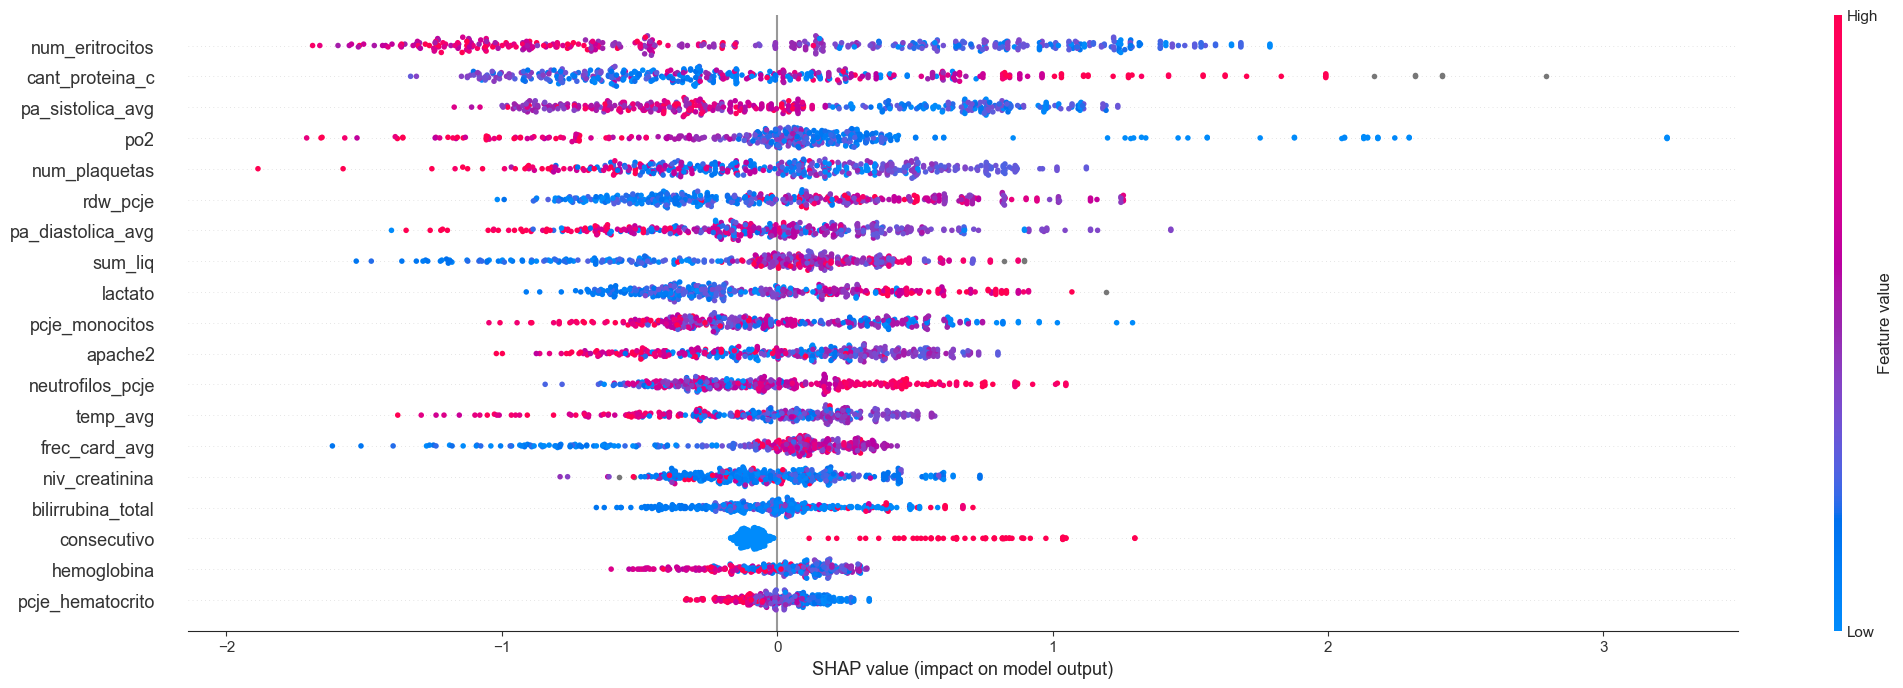

In [91]:
# Crear un objeto explainer de SHAP
explainer = shap.Explainer(xgb_shap_2, x_train_prep)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(x_train_prep)

# Resumen de la importancia de las características
shap.plots.beeswarm(shap_values, max_display=100, plot_size=(25,8))#, show=False)

#plt.savefig('SHAP_XGB_sin_cat.png')

### LightGBM

In [ ]:
# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Búsqueda de hiperparámetros e instanciación del modelo
lgbm_shap_2 = LGBMClassifier(boosting_type='gbdt',
                           n_estimators=290,
                           max_depth=10,
                           subsample=0.6,
                           learning_rate=0.1,
                           subsample_for_bin=20000,
                           random_state=123,
                           verbose=-1)

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'lgbm_feat_eng', lgbm_shap_2, x_train_prep, y_train, x_test_prep, y_test)


Dataset: c_shap_2
           Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    xgb_feat_eng  0.865385   0.842105  0.905660  0.872727  0.864595
10   gbc_feat_eng  0.826923   0.807018  0.867925  0.836364  0.826119
14  lgbm_feat_eng  0.817308   0.814815  0.830189  0.822430  0.817055
18    rf_feat_eng  0.817308   0.774194  0.905660  0.834783  0.815575
29  tree_feat_eng  0.740385   0.716667  0.811321  0.761062  0.738994
34    lr_feat_eng  0.653846   0.654545  0.679245  0.666667  0.653348

Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
3    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
4       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
7      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
8        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
13        voting  0.817308   0.814815  0.830189  0.822430  0.817055
16      ada_orig  0.817308   0.793103  0.867925  0.828829  0.81631

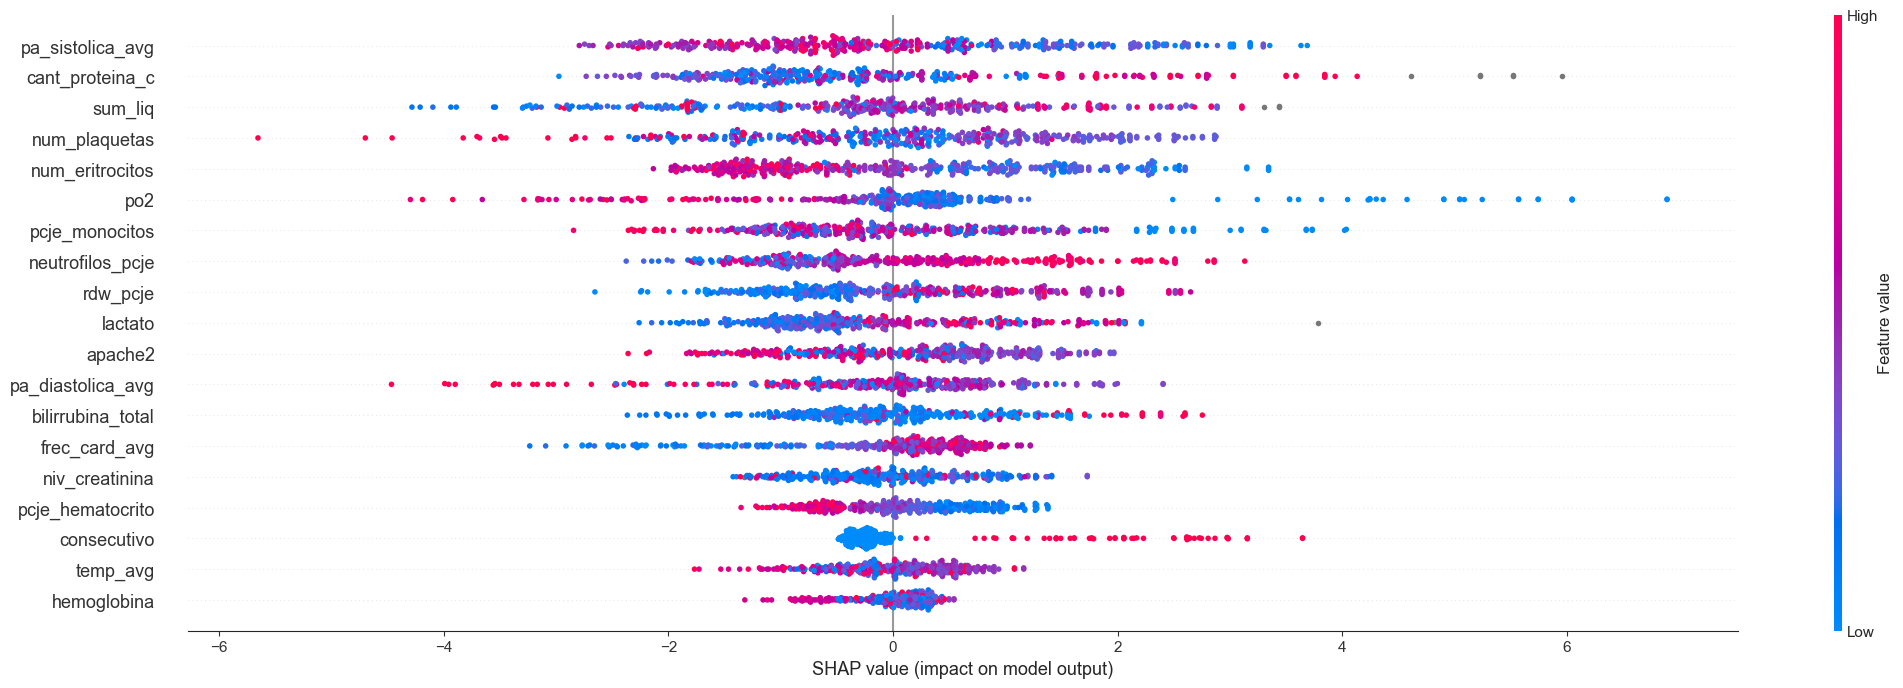

In [93]:
# Crear un objeto explainer de SHAP
explainer = shap.Explainer(lgbm_shap_2, x_train_prep)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(x_train_prep)

# Resumen de la importancia de las características
shap.plots.beeswarm(shap_values, max_display=100, plot_size=(25,8))#, show=False)

#plt.savefig('SHAP_XGB_sin_cat.png')

### Adaboosting

In [ ]:
# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Búsqueda de hiperparámetros e instanciación del modelo
ada_shap_2 = AdaBoostClassifier(estimator=rf_shap_2,
                              n_estimators=50,
                              learning_rate=0.01,
                              algorithm='SAMME',
                              random_state=100)

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'ada_feat_eng', ada_shap_2, x_train_filled, y_train, x_test_filled, y_test)


Dataset: c_shap_2
           Modelo  Accuracy  Precision    Recall  F1_score       AUC
0    xgb_feat_eng  0.865385   0.842105  0.905660  0.872727  0.864595
10   gbc_feat_eng  0.826923   0.807018  0.867925  0.836364  0.826119
14  lgbm_feat_eng  0.817308   0.814815  0.830189  0.822430  0.817055
18   ada_feat_eng  0.817308   0.783333  0.886792  0.831858  0.815945
19    rf_feat_eng  0.817308   0.774194  0.905660  0.834783  0.815575
30  tree_feat_eng  0.740385   0.716667  0.811321  0.761062  0.738994
35    lr_feat_eng  0.653846   0.654545  0.679245  0.666667  0.653348

Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
3    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
4       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
7      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0.827599
8        rf_orig  0.826923   0.818182  0.849057  0.833333  0.826489
13        voting  0.817308   0.814815  0.830189  0.822430  0.8170

### Red neuronal

In [ ]:
# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

red_neuronal_shap_2 = MLPClassifier(hidden_layer_sizes=(30, 30),
                             alpha=0.001,
                             learning_rate_init=0.01,
                             max_iter=1000,
                             solver='adam',
                             activation='tanh',
                             random_state=0,
                             tol=0.00001)

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'red_neuronal_feat_eng', red_neuronal_shap_2, x_train_filled, y_train, x_test_filled, y_test)


Dataset: c_shap_2
                   Modelo  Accuracy  Precision    Recall  F1_score       AUC
0            xgb_feat_eng  0.865385   0.842105  0.905660  0.872727  0.864595
10           gbc_feat_eng  0.826923   0.807018  0.867925  0.836364  0.826119
11  red_neuronal_feat_eng  0.826923   0.786885  0.905660  0.842105  0.825379
15          lgbm_feat_eng  0.817308   0.814815  0.830189  0.822430  0.817055
19           ada_feat_eng  0.817308   0.783333  0.886792  0.831858  0.815945
20            rf_feat_eng  0.817308   0.774194  0.905660  0.834783  0.815575
31          tree_feat_eng  0.740385   0.716667  0.811321  0.761062  0.738994
36            lr_feat_eng  0.653846   0.654545  0.679245  0.666667  0.653348

Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
3    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
4       xgb_orig  0.836538   0.846154  0.830189  0.838095  0.836663
7      lgbm_orig  0.826923   0.857143  0.792453  0.823529  0

### Stacking model

In [ ]:
# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación de los modelos
estimators = [
              ('xgb', xgb_shap_2),
              ('rf', rf_shap_2)
             ]
stack_model_shap_2 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(C=1))

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'stack_model_feat_eng', stack_model_shap_2, x_train_filled, y_train, x_test_filled, y_test)


Dataset: c_shap_2
                   Modelo  Accuracy  Precision    Recall  F1_score       AUC
0            xgb_feat_eng  0.865385   0.842105  0.905660  0.872727  0.864595
2    stack_model_feat_eng  0.855769   0.851852  0.867925  0.859813  0.855531
11           gbc_feat_eng  0.826923   0.807018  0.867925  0.836364  0.826119
12  red_neuronal_feat_eng  0.826923   0.786885  0.905660  0.842105  0.825379
16          lgbm_feat_eng  0.817308   0.814815  0.830189  0.822430  0.817055
20           ada_feat_eng  0.817308   0.783333  0.886792  0.831858  0.815945
21            rf_feat_eng  0.817308   0.774194  0.905660  0.834783  0.815575
32          tree_feat_eng  0.740385   0.716667  0.811321  0.761062  0.738994
37            lr_feat_eng  0.653846   0.654545  0.679245  0.666667  0.653348

Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
4    stack_model  0.836538   0.860000  0.811321  0.834951  0.837033
5       xgb_orig  0.836538   0.846154  0.830189  0.

### Voting

In [ ]:
# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Relleno de valores nulos
x_train_filled = x_train_prep.fillna(0)
x_test_filled = x_test_prep.fillna(0)

# Instanciación de los modelos
# Instanciación de los modelos
estimators = [
              ('xgb', xgb_shap_2),
              #('gbc', gbc_shap_2),
              #('ensemble', stack_model_shap_2),
              ('rf', rf_shap_2)
             ]
vot_shap_2 = VotingClassifier(estimators=estimators, voting='soft')

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'voting_feat_eng', vot_shap_2, x_train_filled, y_train, x_test_filled, y_test)


Dataset: c_shap_2
                   Modelo  Accuracy  Precision    Recall  F1_score       AUC
0            xgb_feat_eng  0.865385   0.842105  0.905660  0.872727  0.864595
2    stack_model_feat_eng  0.855769   0.851852  0.867925  0.859813  0.855531
11           gbc_feat_eng  0.826923   0.807018  0.867925  0.836364  0.826119
12        voting_feat_eng  0.826923   0.807018  0.867925  0.836364  0.826119
13  red_neuronal_feat_eng  0.826923   0.786885  0.905660  0.842105  0.825379
17          lgbm_feat_eng  0.817308   0.814815  0.830189  0.822430  0.817055
21           ada_feat_eng  0.817308   0.783333  0.886792  0.831858  0.815945
22            rf_feat_eng  0.817308   0.774194  0.905660  0.834783  0.815575
33          tree_feat_eng  0.740385   0.716667  0.811321  0.761062  0.738994
38            lr_feat_eng  0.653846   0.654545  0.679245  0.666667  0.653348

Dataset: cols_completa
          Modelo  Accuracy  Precision    Recall  F1_score       AUC
4    stack_model  0.836538   0.860000  0.8

### Matriz de confusión de los primeros tres modelos

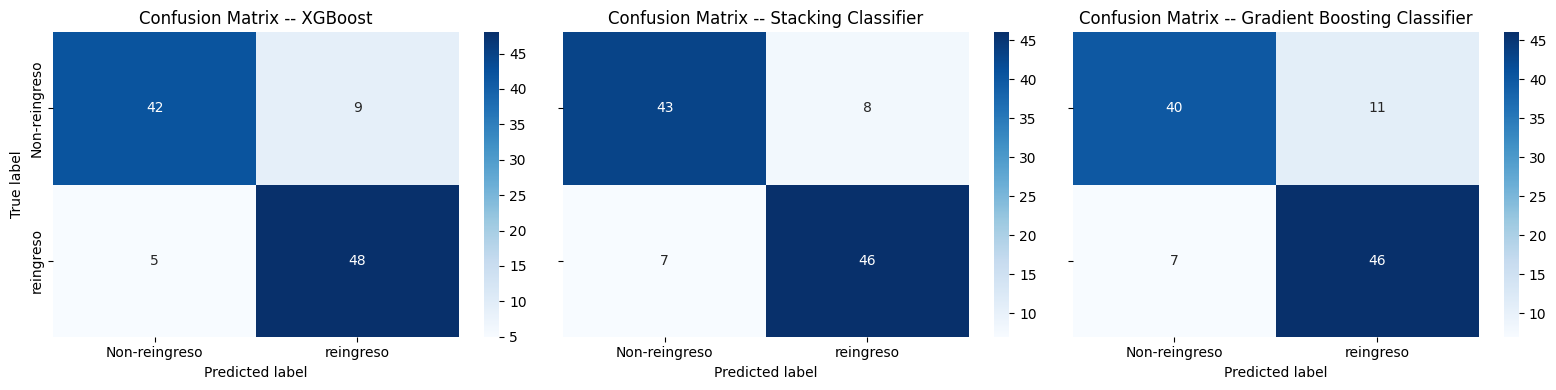

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4), sharey=True)

conf_matrix(xgb_shap_2, x_train_prep, y_train, x_test_prep, y_test, ax=ax[0])
ax[0].set_ylabel('True label')
ax[0].set_xlabel('Predicted label')
ax[0].set_title('Confusion Matrix -- XGBoost')
conf_matrix(stack_model_shap_2, x_train_filled, y_train, x_test_filled, y_test, ax=ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_title('Confusion Matrix -- Stacking Classifier')
conf_matrix(gbc_shap_2, x_train_filled, y_train, x_test_filled, y_test, ax=ax[2])
ax[2].set_xlabel('Predicted label')
ax[2].set_title('Confusion Matrix -- Gradient Boosting Classifier')
plt.tight_layout();

### AUC Models

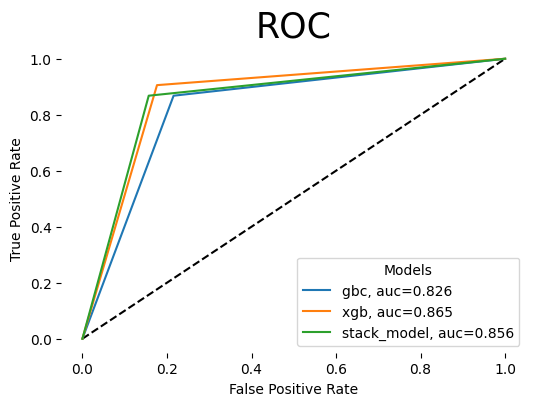

In [74]:
# Para comparar los modelos utilizamos las siguientes métricas: accuracy, precision, recall, f1-score.
# Ahora vamos a usar ROC(Receiver Operating Characteristic) negociación entre sensitivity vs scpecificity
# AUC - área under the curve. Si es grande (cercano a 1) el modelo es bueno distinguiendo entre clases negativas y positivas.
# True positive rate - recall.
# 0.5 indicate that the modelo hasn't power to discreminate between positive and negative classes.
# RF tiene una probabilidad de 77% de distinguir entre default(positivo) y no-default(negativo) clases.
y_pred_proba_gbc = gbc_shap_2.predict(x_test_filled)
fpr4, tpr4, _ = metrics.roc_curve(y_test, y_pred_proba_gbc)
auc4 = metrics.roc_auc_score(y_test, y_pred_proba_gbc)

y_pred_proba_xgb = xgb_shap_2.predict(x_test_prep)
fpr7, tpr7, _ = metrics.roc_curve(y_test, y_pred_proba_xgb)
auc7 = metrics.roc_auc_score(y_test, y_pred_proba_xgb)

y_pred_proba_st = stack_model_shap_2.predict(x_test_filled)
fpr8, tpr8, _ = metrics.roc_curve(y_test, y_pred_proba_st)
auc8 = metrics.roc_auc_score(y_test, y_pred_proba_st)

plt.figure(figsize=(6, 4))
plt.plot([0,1], [0,1], 'k--')
sns.lineplot(x=fpr4,y=tpr4,label='gbc, auc='+ str(round(auc4,3)))
sns.lineplot(x=fpr7,y=tpr7,label='xgb, auc='+ str(round(auc7,3)))
sns.lineplot(x=fpr8,y=tpr8,label='stack_model, auc='+ str(round(auc8,3)))
plt.legend(loc=4, title='Models', facecolor='white')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC', size=25)
plt.box(False);
#plt.savefig('auc_models1.png', format='png', dpi=300, transparent=True, );

In [77]:
models.sort_values(by=['AUC', 'Accuracy'], ascending=False)

Dataset                 Modelo  Accuracy  Precision    Recall  \
34       c_shap_2           xgb_feat_eng  0.865385   0.842105  0.905660   
24   cols_sin_cat            xgb_sin_cat  0.865385   0.830508  0.924528   
38       c_shap_2   stack_model_feat_eng  0.855769   0.851852  0.867925   
29   cols_sin_cat            vot_sin_cat  0.846154   0.862745  0.830189   
8   cols_completa            stack_model  0.836538   0.860000  0.811321   
4   cols_completa               xgb_orig  0.836538   0.846154  0.830189   
28   cols_sin_cat    stack_model_sin_cat  0.826923   0.888889  0.754717   
19   cols_sin_lab            vot_sin_lab  0.826923   0.872340  0.773585   
5   cols_completa              lgbm_orig  0.826923   0.857143  0.792453   
2   cols_completa                rf_orig  0.826923   0.818182  0.849057   
22   cols_sin_cat             rf_sin_cat  0.826923   0.818182  0.849057   
33       c_shap_2           gbc_feat_eng  0.826923   0.807018  0.867925   
39       c_shap_2        voting_feat_eng  0.826923   0.807018  0.867925   
37       c_shap_2  red_neuronal_feat_eng  0.826923   0.786885  0.905660   
14   cols_sin_lab            xgb_sin_lab  0.817308   0.869565  0.754717   
15   cols_sin_lab           lgbm_sin_lab  0.817308   0.840000  0.792453   
9   cols_completa                 voting  0.817308   0.814815  0.830189   
35       c_shap_2          lgbm_feat_eng  0.817308   0.814815  0.830189   
26   cols_sin_cat            ada_sin_cat  0.817308   0.803571  0.849057   
6   cols_completa               ada_orig  0.817308   0.793103  0.867925   
7   cols_completa           red_neuronal  0.817308   0.783333  0.886792   
36       c_shap_2           ada_feat_eng  0.817308   0.783333  0.886792   
32       c_shap_2            rf_feat_eng  0.817308   0.774194  0.905660   
18   cols_sin_lab    stack_model_sin_lab  0.807692   0.866667  0.735849   
23   cols_sin_cat            gbc_sin_cat  0.807692   0.789474  0.849057   
21   cols_sin_cat           tree_sin_cat  0.807692   0.761905  0.905660   
12   cols_sin_lab             rf_sin_lab  0.798077   0.820000  0.773585   
3   cols_completa               gbc_orig  0.798077   0.775862  0.849057   
1   cols_completa              tree_orig  0.798077   0.758065  0.886792   
25   cols_sin_cat           lgbm_sin_cat  0.788462   0.816327  0.754717   
13   cols_sin_lab            gbc_sin_lab  0.788462   0.792453  0.792453   
27   cols_sin_cat   red_neuronal_sin_cat  0.788462   0.771930  0.830189   
16   cols_sin_lab            ada_sin_lab  0.750000   0.764706  0.735849   
31       c_shap_2          tree_feat_eng  0.740385   0.716667  0.811321   
11   cols_sin_lab           tree_sin_lab  0.721154   0.693548  0.811321   
17   cols_sin_lab   red_neuronal_sin_lab  0.711538   0.688525  0.792453   
0   cols_completa                lr_orig  0.682692   0.666667  0.754717   
20   cols_sin_cat             lr_sin_cat  0.663462   0.673077  0.660377   
30       c_shap_2            lr_feat_eng  0.653846   0.654545  0.679245   
10   cols_sin_lab             lr_sin_lab  0.625000   0.625000  0.660377   

    F1_score       AUC  
34  0.872727  0.864595  
24  0.875000  0.864225  
38  0.859813  0.855531  
29  0.846154  0.846467  
8   0.834951  0.837033  
4   0.838095  0.836663  
28  0.816327  0.828339  
19  0.820000  0.827969  
5   0.823529  0.827599  
2   0.833333  0.826489  
22  0.833333  0.826489  
33  0.836364  0.826119  
39  0.836364  0.826119  
37  0.842105  0.825379  
14  0.808081  0.818535  
15  0.815534  0.817795  
9   0.822430  0.817055  
35  0.822430  0.817055  
26  0.825688  0.816685  
6   0.828829  0.816315  
7   0.831858  0.815945  
36  0.831858  0.815945  
32  0.834783  0.815575  
18  0.795918  0.809101  
23  0.818182  0.806881  
21  0.827586  0.805771  
12  0.796117  0.798557  
3   0.810811  0.797077  
1   0.817391  0.796337  
25  0.784314  0.789123  
13  0.792453  0.788383  
27  0.800000  0.787643  
16  0.750000  0.750277  
31  0.761062  0.738994  
11  0.747826  0.719386  
17  0.736842  0.709952  
0   0.707

# Nueva búsqueda de hiperparámetros con PyCaret

In [ ]:
## LIBRERÍAS
from pycaret.classification import *

# DATASET POST INGENIERÍA DE CARACTERÍSTICAS
c_shap_2 = [
            # Variables administrativas
            'consecutivo', 'apache2',
            # Variables fisiológicas
            'temp_avg', 'frec_card_avg', 'pa_diastolica_avg', 'pa_sistolica_avg', 
            # Variables de laboratorio
            'cant_proteina_c', 'lactato', 'po2', 'pcje_monocitos', 'num_eritrocitos', 'niv_creatinina', 'pcje_hematocrito',
            'bilirrubina_total', 'sum_liq',  'rdw_pcje', 'num_plaquetas', 'hemoglobina', 'neutrofilos_pcje',
            # Variable objetivo
            'reingreso'
           ]

In [11]:
# CONFIGURACIÓN DEL ENTORNO
model_setup = setup(data=data[c_shap_2], target='reingreso', session_id=123)

In [12]:
# CREACIÓN DEL MODELO XGBOOST
xgb = create_model(estimator='xgboost')

In [ ]:
# HIPERPARÁMETROS DEL MODELO CREADO
print(xgb)

In [ ]:
# AFINADO DEL MODELO CREADO
tuned_xgb = tune_model(estimator=xgb,
                       optimize='AUC')

Initiated  . . . . . . . . . . . . . . . . . .                   12:17:21
Status     . . . . . . . . . . . . . . . . . .       Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .  Extreme Gradient Boosting

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [15]:
# HIPERPARÁMETROS DEL MODELO AFINADO
print(tuned_xgb)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)


In [ ]:
#XGBOOST CON PYCARET

# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Instanciación del modelo
xgb_pycaret = XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=np.nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic')

# Métricas de evaluación de la predicción del modelo
conf_matrix(xgb_pycaret, x_train_prep, y_train, x_test_prep, y_test)

# Validación del modelo XGBoost elegido

In [ ]:
# NUEVAMENTE CREAMOS EL MODELO XGBOOST CON EL GRUPO DE VARIABLES 'c_shap_2'

# Datos para el modelo
x = data[c_shap_2]
y = data['reingreso']

# División del set de datos de entrenamiento (80 %) y test (20 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Codificación de variables categóricas
x_train_prep, x_test_prep = encoder(x_train=x_train,
                                    x_test=x_test)

# Instanciación del modelo
xgb_shap_2 = XGBClassifier(n_estimators=200,
                         max_depth=9,
                         subsample=0.9,
                         learning_rate=0.1,
                         random_state=21)

# Métricas de evaluación de la predicción del modelo
metricas_eval('c_shap_2', 'xgb_validacion', xgb_shap_2, x_train_prep, y_train, x_test_prep, y_test)


Dataset: c_shap_2
           Modelo  Accuracy  Precision   Recall  F1_score       AUC
0  xgb_validacion  0.865385   0.842105  0.90566  0.872727  0.864595


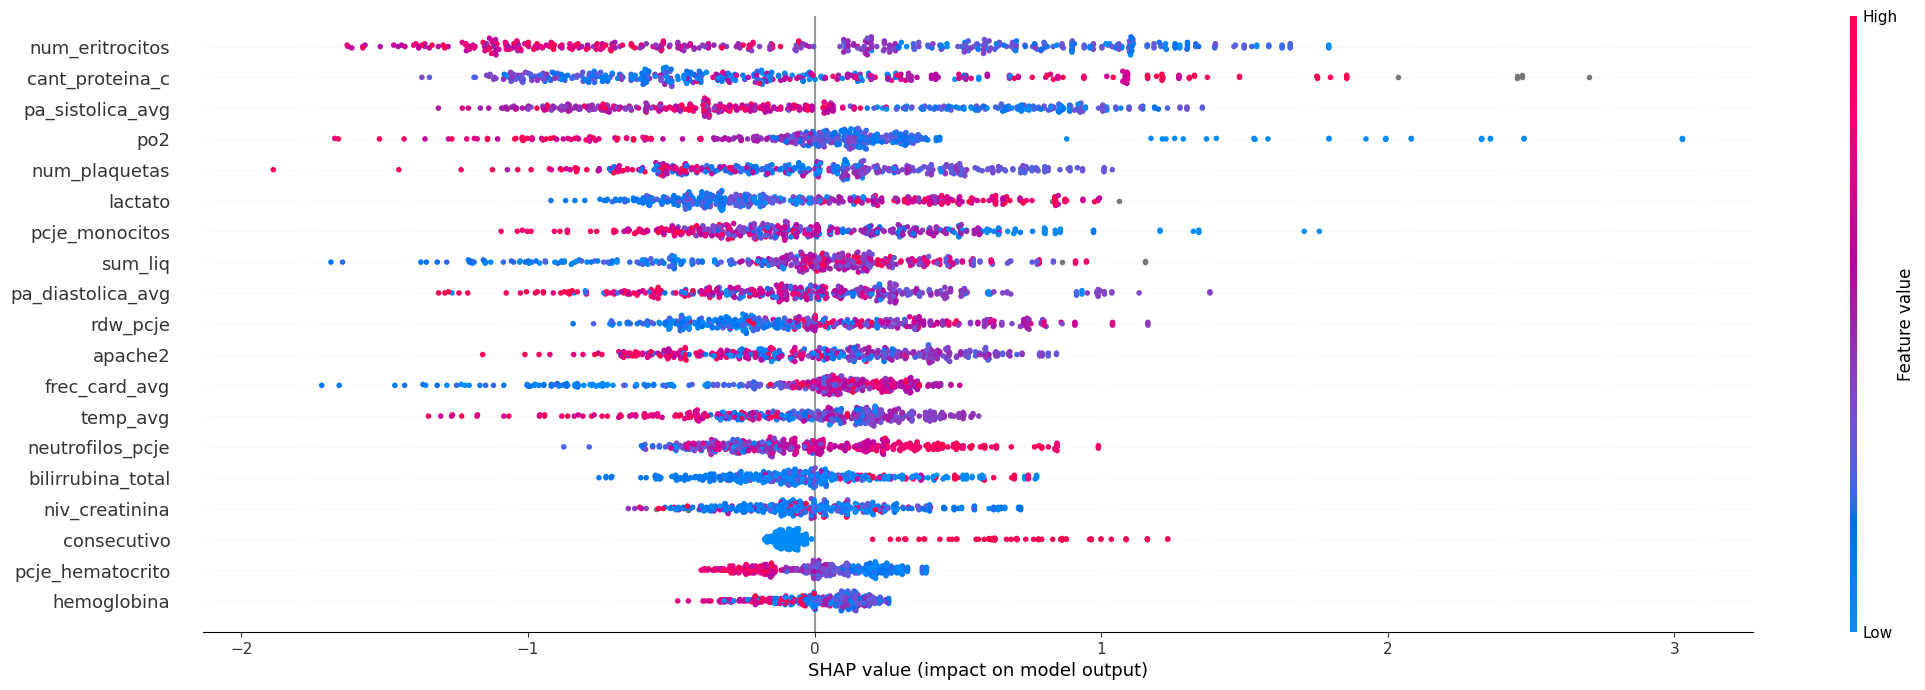

In [11]:
# Crear un objeto explainer de SHAP
explainer = shap.Explainer(xgb_shap_2, x_train_prep)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(x_train_prep)

# Resumen de la importancia de las características
shap.plots.beeswarm(shap_values, max_display=100, plot_size=(25,8))#, show=False)

accuracy: 0.7391304347826086
precision: 0.6818181818181818
recall: 0.75
f1_score 0.7142857142857143
auc 0.7403846153846154


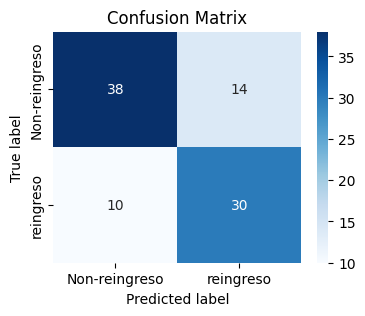

In [13]:
# VALIDACIÓN DEL MODELO CON LOS DATOS AÚN NO VISTOS

# Datos para el modelo
x = data_unseen[c_shap_2]
y = data_unseen['reingreso']

# Codificación de variables categóricas
x_train_prep = encoder(x_train=x)

# Métricas de evaluación de la predicción del modelo
y_pred = xgb_shap_2.predict(x_train_prep)

print(f'accuracy: {accuracy_score(y, y_pred)}')
print(f'precision: {precision_score(y, y_pred)}')
print(f'recall: {recall_score(y, y_pred)}')
print(f'f1_score {f1_score(y, y_pred)}')
print(f'auc {roc_auc_score(y, y_pred)}')

plt.subplots(figsize=(4, 3))
ConfMatrix = confusion_matrix(y, y_pred)
sns.heatmap(ConfMatrix, annot=True, cmap='Blues', fmt='d',
                xticklabels=['Non-reingreso', 'reingreso'],
                yticklabels=['Non-reingreso','reingreso'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix');

# Subida de experimentos de modelos en MLFLOW

In [26]:
# LIBRERÍAS
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score

mlflow.set_experiment('ICU_readmissions')

2024/11/27 14:46:23 INFO mlflow.tracking.fluent: Experiment with name 'ICU_readmissions' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/lerma/OneDrive/Escritorio/USB/TG-Hospital/TG_Final/mlruns/289480742129163536', creation_time=1732736783920, experiment_id='289480742129163536', last_update_time=1732736783920, lifecycle_stage='active', name='ICU_readmissions', tags={}>

In [29]:
# MÉTRICAS A GUARDAR
def eval_metrics(actual, pred):
    accu = accuracy_score(actual, pred)
    auc = roc_auc_score(actual, pred)
    prec = precision_score(actual, pred)
    rec = recall_score(actual, pred)
    f1 = f1_score(actual, pred)
    return accu, auc, prec, rec, f1

# INSTANCIACIÓN Y GUARDADO DE MODELOS
def train_model(nombre, modelo, columnas):
    # Datos para el modelo
    x = columnas
    y = data['reingreso']

    # División del set de datos de entrenamiento (80 %) y test (20 %)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
    
    # Codificación de las variables categóricas y escalado
    x_train_prep, x_test_prep = encoder(x_train=x_train,
                                        x_test=x_test)
    
    # Relleno de valores nulos
    x_train_filled = x_train_prep.fillna(x_train_prep.mean())
    x_test_filled = x_test_prep.fillna(x_test_prep.mean())


    with mlflow.start_run(run_name=nombre):
        model = modelo
        model.fit(x_train_filled, y_train)

        predicted_reing = model.predict(x_test_filled)

        (accu, auc, prec, rec, f1) = eval_metrics(y_test, predicted_reing)

        mlflow.log_param('modelo', modelo)
        mlflow.log_param('dataset', columnas)
        mlflow.log_metric('accuracy', accu)
        mlflow.log_metric('auc', auc)
        mlflow.log_metric('precision', prec)
        mlflow.log_metric('recall', rec)
        mlflow.log_metric('f1_score', f1)

        mlflow.sklearn.log_model(model, 'model', registered_model_name=nombre)

In [30]:
# SUBIDA DE LOS EXPERIMENTOS CON MEJOR DESEMPEÑO
train_model(nombre='xgb_model', 
            modelo=xgb_orig,
            columnas=data[cols_completa])

train_model(nombre='stack_model', 
            modelo=stack_model,
            columnas=data[cols_completa])

train_model(nombre='xgb_model_sin_categ', 
            modelo=xgb_sin_cat,
            columnas=data[cols_sin_cat])

train_model(nombre='stack_model_sin_categ', 
            modelo=stack_model_sin_cat,
            columnas=data[cols_sin_cat])

train_model(nombre='lgbm_model_sin_var_lab', 
            modelo=lgbm_sin_lab,
            columnas=data[cols_sin_lab])

train_model(nombre='xgb_model_sin_var_lab', 
            modelo=xgb_sin_lab,
            columnas=data[cols_sin_lab])

train_model(nombre='stack_model_feat_engin', 
            modelo=stack_model_shap_2,
            columnas=data[c_shap_2])

train_model(nombre='xgb_model_feat_engin', 
            modelo=xgb_shap_2,
            columnas=data[c_shap_2])

#train_model(nombre='xgb_model_validacion', 
#            modelo=xgb_shap_2,
#            columnas=data_unseen[c_shap_2])

2024/11/27 14:47:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'xgb_model'.
Created version '1' of model 'xgb_model'.
2024/11/27 14:47:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'stack_model'.
Created version '1' of model 'stack_model'.
2024/11/27 14:47:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'xgb_model_sin_categ'.
Created version '1' of model 'xgb_model_sin_categ'.
2024/11/27 14:47:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` param

[LightGBM] [Info] Number of positive: 212, number of negative: 202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2504
[LightGBM] [Info] Number of data points in the train set: 414, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512077 -> initscore=0.048319
[LightGBM] [Info] Start training from score 0.048319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

2024/11/27 14:47:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'lgbm_model_sin_var_lab'.
Created version '1' of model 'lgbm_model_sin_var_lab'.
2024/11/27 14:47:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'xgb_model_sin_var_lab'.
Created version '1' of model 'xgb_model_sin_var_lab'.
2024/11/27 14:47:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'stack_model_feat_engin'.
Created version '1' of model 'stack_model_feat_engin'.
2024/11/27 14:48:00 WARNING mlflow.models.model: Model logged without a signature

In [27]:
# CONFIGURACIÓN DEL SERVIDOR DE SEGUIMIENTO
from pyngrok import ngrok
# terminate open tunnels if existing
ngrok.kill()

# Setting the authtoken
ngrok.set_auth_token('2dzNmf2zYK7cPfpbpqsT2tDXMPD_2a8LgF5T4CJWeCVngA5ET')

# Open a HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr='5000', proto='http', bind_tls=True)
print('Mlflow Tracking UI:', ngrok_tunnel.public_url)

Mlflow Tracking UI: https://1a77-2800-e2-280-f5e-a1d0-fd1c-75b9-9f75.ngrok-free.app


In [31]:
# INTERFAZ DE USUARIO (CORRER ANTES DE ENTRAR AL LINK DEL SERVIDOR DE SEGUIMIENTO)
!mlflow ui

^C
